In [270]:
!pip install pyomo
!wget https://people.montefiore.uliege.be/cornelusse/utils/ampl.linux-intel64.zip
!unzip /content/ampl.linux-intel64.zip
!chmod +x /content/ampl.linux-intel64/ipopt # To make sure it can be executed
!chmod +x /content/ampl.linux-intel64/cbc # To make sure it can be executed

--2025-08-18 14:21:42--  https://people.montefiore.uliege.be/cornelusse/utils/ampl.linux-intel64.zip
Resolving people.montefiore.uliege.be (people.montefiore.uliege.be)... 139.165.57.148
Connecting to people.montefiore.uliege.be (people.montefiore.uliege.be)|139.165.57.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17486900 (17M) [application/zip]
Saving to: ‘ampl.linux-intel64.zip.7’

ampl.linux-intel64. 100%[===================>]  16.68M  4.91MB/s    in 3.4s    

2025-08-18 14:21:48 (4.91 MB/s) - ‘ampl.linux-intel64.zip.7’ saved [17486900/17486900]

Archive:  /content/ampl.linux-intel64.zip
replace __MACOSX/._ampl.linux-intel64? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [271]:
!pip install pandapower --upgrade

In [272]:
!pip install networkx

In [273]:
!pip install gurobipy  # install gurobipy, if not already installed

In [274]:
import gurobipy as gp
import time
import pandas as pd
import xarray as xr
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
import pyomo.environ as pyo
import math
import pandapower as pp


# Create a new graph
G = nx.DiGraph()

In [275]:
def create_network():

    import pandapower as pp

# Crée le réseau
    net = pp.create_empty_network()

# Bases
    Pbase = 100  # MVA
    Vbase_high = 110  # kV
    Vbase_medium = 20  # kV
    Vbase_low = 0.4  # kV

# Buses
    b0 = pp.create_bus(net, vn_kv=Vbase_high, name="Bus grid", geodata=(0,10))
    b1 = pp.create_bus(net, vn_kv=Vbase_high, name="DSO 1", geodata=(5,12))
    b2 = pp.create_bus(net, vn_kv=Vbase_high, name="DSO 2", geodata=(5,8))
    b3 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus MV_1", geodata=(10,12))
    b4 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus MV_2", geodata=(10,8))
    b5 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus LV_1", geodata=(15,12))
    b6 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus LV_2", geodata=(15,8))
    b7 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus éolien", geodata=(10,14))
    b8 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus industriel", geodata=(10,10))
    b9 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus load", geodata=(15,14))
    b10 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus PV", geodata=(15,10))
    b11 = pp.create_bus(net, vn_kv=Vbase_high, name="TSO 1", geodata=(2,12))
    b12 = pp.create_bus(net, vn_kv=Vbase_high, name="TSO 2", geodata=(2,8))

# Lignes
    pp.create_line(net, b0, b1, length_km=12, std_type='149-AL1/24-ST1A 110.0', name="line1")
    pp.create_line(net, b1, b2, length_km=10, std_type='149-AL1/24-ST1A 110.0', name="line2")
    pp.create_line(net, b0, b2, length_km=10, std_type='149-AL1/24-ST1A 110.0', name="line3")
    pp.create_line(net, b3, b7, length_km=0.23, std_type='NA2XS2Y 1x185 RM/25 12/20 kV', name="line4")
    pp.create_line(net, b4, b8, length_km=0.3, std_type='NA2XS2Y 1x185 RM/25 12/20 kV', name="line5")
    pp.create_line(net, b5, b9, length_km=3, std_type='94-AL1/15-ST1A 0.4', name="line6")
    pp.create_line(net, b6, b10, length_km=0.45, std_type='94-AL1/15-ST1A 0.4', name="line7")
    pp.create_line(net, b0, b11, length_km=16, std_type='149-AL1/24-ST1A 110.0', name= 'line8')
    pp.create_line(net, b11, b1, length_km=24, std_type='149-AL1/24-ST1A 110.0', name= 'line9')
    pp.create_line(net, b0, b12, length_km=22, std_type='149-AL1/24-ST1A 110.0', name= 'line10')
    pp.create_line(net, b12, b2, length_km=16, std_type='149-AL1/24-ST1A 110.0', name= 'line11')

# Transformateurs
    pp.create_transformer(net, b1, b3, std_type="25 MVA 110/20 kV", name="TR_1")
    pp.create_transformer(net, b2, b4, std_type="25 MVA 110/20 kV", name="TR_2")
    pp.create_transformer(net, b3, b5, std_type="0.4 MVA 20/0.4 kV", name="TR_3")
    pp.create_transformer(net, b4, b6, std_type="0.4 MVA 20/0.4 kV", name="TR_4")

# Éléments de bus
    pp.create_ext_grid(net, bus=b0, vm_pu=1.00, name="Grid Connection")
    pp.create_load(net, bus=b9, p_mw=0.02, q_mvar=0.02, name="Residential Load")
    pp.create_gen(net, bus=b10, p_mw=0.2, vm_pu=1.00, name="PV", max_q_mvar=200, min_q_mvar=0, max_p_mw=300, min_p_mw=0, controllable=False)
    pp.create_gen(net, bus=b7, p_mw=6.5, vm_pu=1.0, name="Wind Turbine", controllable=False)
    pp.create_load(net, bus=b8, p_mw=6, q_mvar=1.8, name="Industry")
    pp.create_load(net, bus=b11, p_mw=20, q_mvar=9, name="Datacenter")
    pp.create_load(net, bus=b12, p_mw=50, q_mvar=24, name="Big industry")

# Donner accès à net
    return net

In [380]:
def create_digraph():
  net = create_network()

  import json
  import networkx as nx
  import matplotlib.pyplot as plt
# 1. Conversion du réseau Pandapower en DiGraph
# ================================
  G = nx.Graph()

# Créer les positions à partir de la colonne "geo"
  pos = {}
  for idx, row in net.bus.iterrows():
  # Extraire le champ 'geo' qui est une chaîne de caractères représentant un dictionnaire JSON
      geo_data = row['geo']

  # Convertir la chaîne JSON en un dictionnaire Python
      geo_dict = json.loads(geo_data)

  # Extraire la liste des coordonnées
      coordinates = geo_dict["coordinates"]

  # Ajouter les coordonnées dans le dictionnaire pos
      pos[idx] = tuple(coordinates)  # Assigner les coordonnées sous forme de tuple

# Ajouter les nœuds (avec le nom comme label) and voltage
  for idx, row in net.bus.iterrows():
      G.add_node(idx, label=row["name"], pos=pos[idx], vn_kv=row["vn_kv"])


# Ajouter les arêtes pour les lines
  for _, row in net.line.iterrows():
      G.add_edge(row["from_bus"], row["to_bus"], type="line", name=row["name"], length=row["length_km"], std_type=row["std_type"])

# Ajouter les arêtes pour les transformateurs
  for _, row in net.trafo.iterrows():
      G.add_edge(row["hv_bus"], row["lv_bus"], type="trafo", name=row["name"], std_type = None)

# Ajouter les générateurs et les charges comme attributs aux nœuds
  for _, row in net.gen.iterrows():
      G.nodes[row["bus"]]["type"] = "gen"
      G.nodes[row["bus"]]["gen_name"] = row["name"]
      G.nodes[row["bus"]]["gen_power"] = row["p_mw"]

  for _, row in net.load.iterrows():
      G.nodes[row["bus"]]["type"] = "load"
      G.nodes[row["bus"]]["load_name"] = row["name"]
      G.nodes[row["bus"]]["load_power"] = row["p_mw"]

  for _, row in net.ext_grid.iterrows():
      G.nodes[row["bus"]]["type"] = "ext_grid"
      G.nodes[row["bus"]]["grid_name"] = row["name"]

# 2. Ajout des puissances consommées et injectées aux nœuds
# ================================
  nx.set_node_attributes(G, 0.0, "P_load")
  nx.set_node_attributes(G, 0.0, "P_gen")

# Charges
  for _, row in net.load.iterrows():
      G.nodes[row["bus"]]["P_load"] += row["p_mw"]
      print(row)

# Générateurs
  for _, row in net.gen.iterrows():
      G.nodes[row["bus"]]["P_gen"] += row["p_mw"]

# Source externe
  for _, row in net.ext_grid.iterrows():
      G.nodes[row["bus"]]["P_gen"] += 0

# Calculate P_net
  for n in G.nodes:
      G.nodes[n]["P_net"] = G.nodes[n]["P_gen"] - G.nodes[n]["P_load"]

# Create subnetworks (NetworkX DiGraphs) from the main graph G
  network1_buses = [0, 1, 2, 11,12]
  network2_buses = [3, 7, 5, 9, 10]
  network3_buses = [4, 8, 6]

# Assign G1 to G and then add power attributes to nodes in G
  #G = G.subgraph(network1_buses)

  for n in G.nodes:
      G.nodes[n]["P"] = G.nodes[n]["P_net"] # Assign P_net to 'P' attribute

# 3. Préparer les couleurs des nœuds en fonction de P_net
# ================================
  node_colors = []
  for n, data in G.nodes(data=True):
      if data["P_net"] > 0:
          node_colors.append("green")   # producteur
      elif data["P_net"] < 0:
          node_colors.append("red")     # consommateur
      else:
          node_colors.append("gray")    # neutre

# 4. Préparer les labels : Nom + P_net
# ================================
  labels = {n: f"{data['label']}\nP={round(data['P_net'],2)}MW"
            for n, data in G.nodes(data=True)}

# 5. Function to plot the network
# ================================
  def plot_network():
      pos = nx.get_node_attributes(G, 'pos')

      plt.figure(figsize=(12, 8))
      nx.draw(
          G, pos,
          with_labels=True, labels=labels,
          node_size=1200, node_color=node_colors,
          edgecolors="black", font_size=8,
          alpha=0.85
          )

  # Labels des arêtes (type ligne ou trafo)
      edge_labels = nx.get_edge_attributes(G, 'type')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

      plt.title("Réseau électrique test")
      plt.axis("equal")
      plt.show()


  return G, plot_network()

name               Residential Load
bus                               9
p_mw                           0.02
q_mvar                         0.02
const_z_percent                 0.0
const_i_percent                 0.0
sn_mva                          NaN
scaling                         1.0
in_service                     True
type                            wye
Name: 0, dtype: object
name               Industry
bus                       8
p_mw                    6.0
q_mvar                  1.8
const_z_percent         0.0
const_i_percent         0.0
sn_mva                  NaN
scaling                 1.0
in_service             True
type                    wye
Name: 1, dtype: object
name               Datacenter
bus                        11
p_mw                     20.0
q_mvar                    9.0
const_z_percent           0.0
const_i_percent           0.0
sn_mva                    NaN
scaling                   1.0
in_service               True
type                      wye
Name: 2, dtype

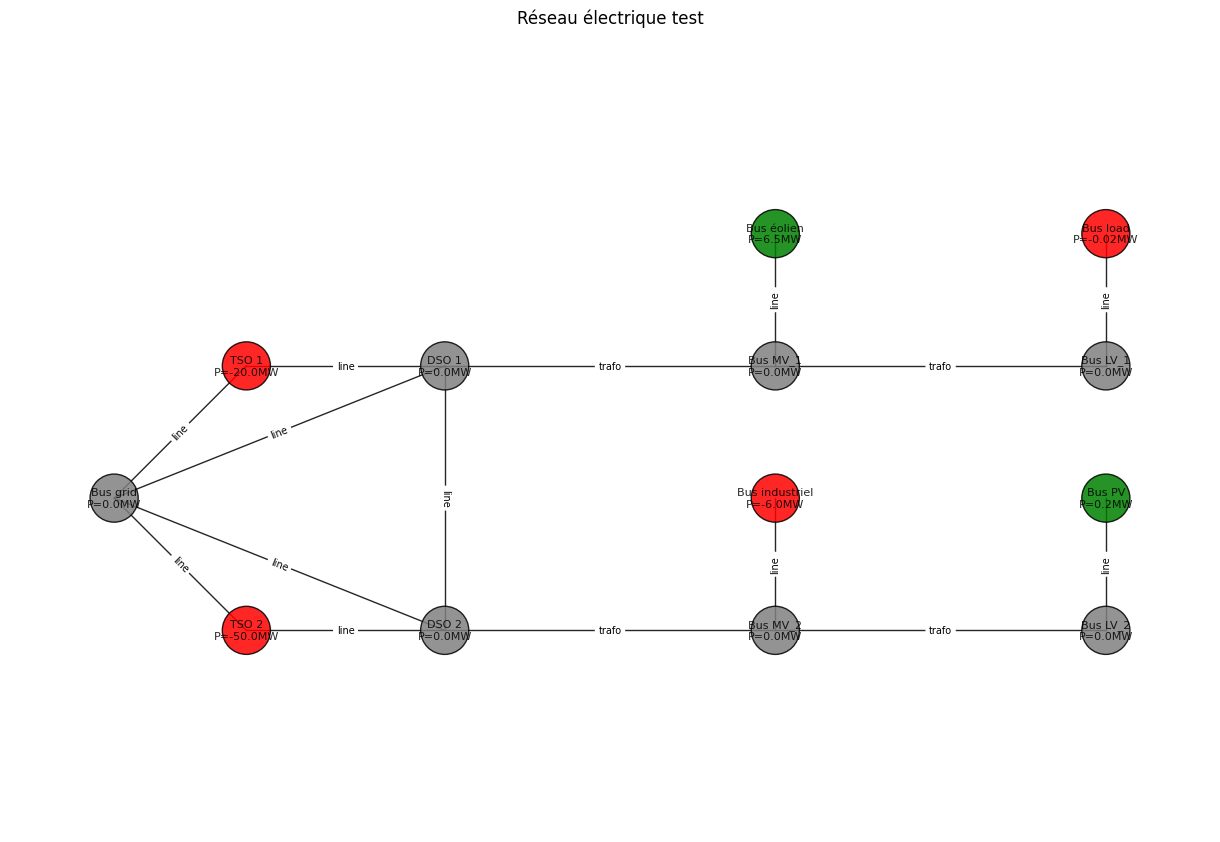

Value of G.nodes[11]['P'] after updating G: -20.0


In [381]:
G, plot_func = create_digraph()
print(f"Value of G.nodes[11]['P'] after updating G: {G.nodes[11]['P']}")

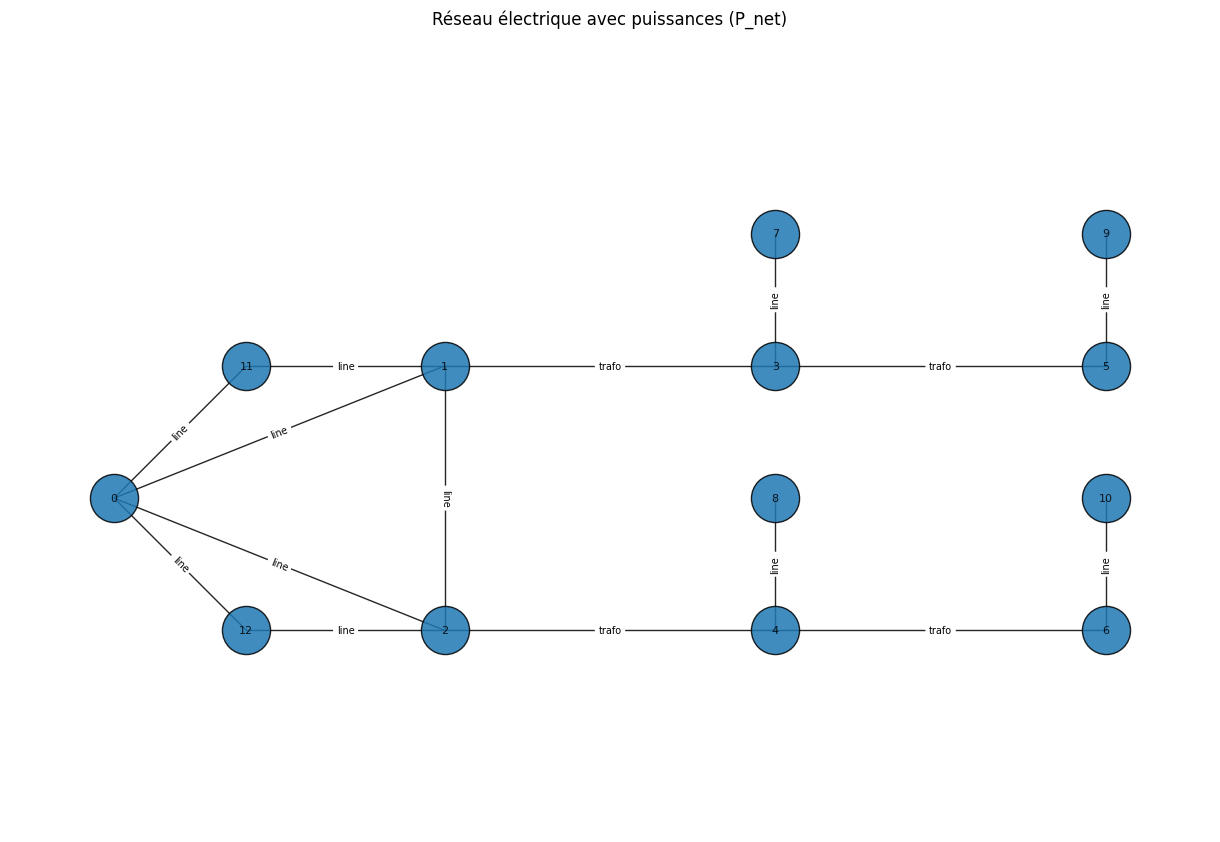

In [382]:
def plot_network(G):
      pos = nx.get_node_attributes(G, 'pos')

      plt.figure(figsize=(12, 8))
      nx.draw(
          G, pos,
          with_labels=True,
          node_size=1200,
          edgecolors="black", font_size=8,
          alpha=0.85
          )

  # Labels des arêtes (type ligne ou trafo)
      edge_labels = nx.get_edge_attributes(G, 'type')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

      plt.title("Réseau électrique avec puissances (P_net)")
      plt.axis("equal")
      plt.show()

plot_network(G)

In [383]:
# Define base values for the per-unit system
s_base = 100  # MVA


v_base_high = 110 # kV (From the create_network function)

# Calculate base current (I_base)
# S_base = V_base * I_base (for single phase, or sqrt(3)*V_base*I_base for three phase)
# Assuming three-phase system: I_base = S_base / (sqrt(3) * V_base)
i_base_high = s_base / (math.sqrt(3) * v_base_high) # kA

# Calculate base impedance (Z_base)
# Z_base = V_base^2 / S_base
z_base_high = v_base_high**2 / s_base # ohms

# Calculate base susceptance (B_base)
# B_base = 1 / Z_base = S_base / V_base^2
b_base_high = s_base / v_base_high**2 # Siemens

print(f"Base Power (S_base): {s_base} MVA")
print(f"Base Voltage (V_base_high): {v_base_high} kV")
print(f"Base Current (I_base_high): {i_base_high} kA")
print(f"Base Impedance (Z_base_high): {z_base_high} ohms")
print(f"Base Susceptance (B_base_high): {b_base_high} Siemens")

Base Power (S_base): 100 MVA
Base Voltage (V_base_high): 110 kV
Base Current (I_base_high): 0.524863881081478 kA
Base Impedance (Z_base_high): 121.0 ohms
Base Susceptance (B_base_high): 0.008264462809917356 Siemens


In [384]:
# Define the maximum current in kA
I_max_kA = 0.47

# Get the base current in kA from the previous calculation
# Assuming i_base_high is the relevant base current for the lines in the model
I_base_kA = i_base_high

# Calculate the upper bound for current in per-unit
I_max_pu = I_max_kA / I_base_kA

# The lower bound for current is the negative of the upper bound, assuming symmetrical limits
I_min_pu = -I_max_pu

print(f"Maximum Current (kA): {I_max_kA}")
print(f"Base Current (kA): {I_base_kA}")
print(f"Upper bound for current (per-unit): {I_max_pu}")
print(f"Lower bound for current (per-unit): {I_min_pu}")

# Update the Pyomo model's bounds if they are defined globally or need to be updated
# Assuming I_min and I_max are global variables used in the Pyomo model definition
I_min = I_min_pu
I_max = I_max_pu

print("\nUpdated global current bounds (per-unit):")
print(f"I_min: {I_min}")
print(f"I_max: {I_max}")

Maximum Current (kA): 0.47
Base Current (kA): 0.524863881081478
Upper bound for current (per-unit): 0.8954702675131095
Lower bound for current (per-unit): -0.8954702675131095

Updated global current bounds (per-unit):
I_min: -0.8954702675131095
I_max: 0.8954702675131095


In [385]:
def calculate_current_bounds(line_type, v_base):
    """
    Calculates the upper and lower bounds for current in per-unit
    based on the line type's maximum current capacity.

    Args:
        line_type (str): The type of the transmission line.
        i_base_kA (float): The base current in kA for the system.

    Returns:
        tuple: A tuple containing (I_min_pu, I_max_pu).
               Returns (None, None) if the line type is not found.
    """
    # Define a dictionary mapping line types to their maximum current capacity in kA
    # NOTE: This is a placeholder. You should populate this dictionary
    # with the actual maximum current capacities for your line types.
    i_base_kA = s_base / (math.sqrt(3) * v_base) # kA


    line_type_max_current_kA = {
        '149-AL1/24-ST1A 110.0': 0.47, # Example value for 110 kV lines
        'NA2XS2Y 1x185 RM/25 12/20 kV': 0.3, # Example value for 20 kV lines
        '94-AL1/15-ST1A 0.4': 0.15 # Example value for 0.4 kV lines
    }

    if line_type in line_type_max_current_kA:
        I_max_kA = line_type_max_current_kA[line_type]

        # Calculate the upper bound for current in per-unit
        I_max_pu = I_max_kA / i_base_kA

        # The lower bound for current is the negative of the upper bound
        I_min_pu = -I_max_pu

        return I_min_pu, I_max_pu, i_base_kA

    elif line_type == None:
        return -1000, 1000
    else:
        return None, None

# Example usage (assuming i_base_high is already defined):
line1_type = '149-AL1/24-ST1A 110.0'
I_min_line1, I_max_line1, i_base_kA = calculate_current_bounds(line1_type, i_base_high)

# line4_type = 'NA2XS2Y 1x185 RM/25 12/20 kV'
# I_min_line4, I_max_line4 = calculate_current_bounds(line4_type, i_base_high)
# print(f"\nCurrent bounds for {line4_type}: [{I_min_line4}, {I_max_line4}]")

In [386]:
def length (i, j):
    xi, yi = G.nodes[i]['pos']
    xj, yj = G.nodes[j]['pos']
    return (math.hypot(xi - xj, yi - yj))*10/1000  # distance euclidienne, *10/1000 (pixel/km)
length(0, 1)

0.053851648071345036

In [387]:
#Calculate the susceptance of each line in Siemens per km
strange = 1000
for u, v in G.edges():
    G[u][v]['b'] = length(u,v)* 200*10**-6 *strange
    print(G[u][v]['b'])


0.010770329614269008
0.010770329614269008
0.005656854249492381
0.005656854249492381
0.008
0.006
0.009999999999999998
0.006
0.009999999999999998
0.004
0.009999999999999998
0.004
0.009999999999999998
0.004
0.004


In [388]:
#Constant definition
V_min = 0.9
V_max = 1.1


P_min = -1
P_max = 1

theta_min = -180
theta_max = 180


alpha = 1


In [389]:
def get_base_node_voltage_kv(node_index):
  """
  Returns the voltage (vn_kv) for a given node index from the graph.

  Args:
    node_index: The index of the node in the graph.

  Returns:
    The voltage in kV for the specified node.
  """
  # Assuming 'G' is the NetworkX DiGraph object created earlier
  # Access the 'vn_kv' attribute for the given node_index
  return G.nodes[node_index]['vn_kv']

# Example usage:
# To get the voltage for node 0:
# voltage_node_0 = get_node_voltage_kv(0)
# print(f"Voltage at node 0: {voltage_node_0} kV")

# To get the voltage for node 3:
voltage_node_3 = get_base_node_voltage_kv(0)
print(f"Voltage at node 3: {voltage_node_3} kV")

Voltage at node 3: 110.0 kV


In [390]:
m = pyo.ConcreteModel()
# Define base values for the per-unit system
s_base = 100  # MVA
v_base_high = 110 # kV (From the create_network function)

m.Nodes = pyo.Set(initialize= [b for b in G.nodes])
m.Lines = pyo.Set(initialize= [l for l in G.edges])
m.i = pyo.Set(initialize=[0, 1]) # Initialize m.i with two generic elements
m.j = pyo.Set(initialize= [0, 1])
#m.children = pyo.Set(initialize= [1, 2])
m.parents = pyo.Set(initialize = [0])

# Get the line indices from the model
line_indices = list(m.Lines)

# You can print the indices
print("Indices of all lines:")
for line in line_indices:
    print(line)

m.P = pyo.Param(m.Nodes, initialize = {n: - G.nodes[n].get('P') for n in G.nodes}, domain = pyo.Reals, mutable=True) # Make P mutable

m.I_min = pyo.Param(m.Lines, initialize = {(i,j): calculate_current_bounds(G.edges[i,j]["std_type"], get_base_node_voltage_kv(i))[0] for (i,j) in m.Lines}, domain = pyo.Reals)
m.I_max = pyo.Param(m.Lines, initialize = {(i,j): calculate_current_bounds(G.edges[i,j]["std_type"], get_base_node_voltage_kv(i))[1] for (i,j) in m.Lines}, domain = pyo.Reals)

print(m.I_min[(0,1)])
print(m.I_max[(0,1)])

# Variables principales
m.F = pyo.Var(m.Lines, m.i, m.j, domain=pyo.Reals)     # active power flow through lines
m.I = pyo.Var(m.Lines,  m.i, m.j, domain=pyo.Reals)  # current flowing through lines
m.theta = pyo.Var(m.Nodes,  m.i, m.j, domain=pyo.Reals)  # phase angle of the voltage
m.V = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.NonNegativeReals)  # voltage magnitude at each node
m.E = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.Reals) #net power injection/consumption
m.P_plus = pyo.Var(m.parents, m.i, m.j, domain=pyo.Reals) #power entering the operational graph
#m.P_minus = pyo.Var(m.children, m.i, m.j, domain=pyo.Reals) #power leaving the operational graph

#m.P_C_set = pyo.Var(m.children, m.i, domain=pyo.Reals) #vertices of the power envelope at each child node

#m.P_C_min = pyo.Var(m.children, m.i, m.j, domain=pyo.Reals)
#m.P_C_max = pyo.Var(m.children, m.i, m.j,  domain=pyo.Reals)

m.V_P = pyo.Param(m.j, initialize = {0: 0.9, 1: 1.1}, domain =pyo.NonNegativeReals)

m.O = pyo.Var(domain= pyo.NonNegativeReals)

for u in G.nodes():
  if G.nodes[u].get('P', 0.0) == 0:
    m.P[u] = 0
  else:
    G.nodes[u]['P_pu'] = G.nodes[u].get('P', 0.0) / s_base
    m.P[u] = - G.nodes[u]['P_pu']

"""# Convert P parameter to per-unit
for n in G.nodes:
    # Assuming P is in MW, convert to per-unit
    G.nodes[n]['P'] = G.nodes[n].get('P', 0.0) / s_base
    m.P[n] = G.nodes[n]['P']"""


# Convert susceptance 'b' on edges to per-unit
for u, v in G.edges():
    # Assuming 'b' is in Siemens/km, convert to per-unit
    # b_pu = b_actual * (V_base^2 / S_base)
    # V_base is assumed to be v_base_high (110 kV)
    G[u][v]['b_pu'] = G[u][v].get('b', 0.0) * (get_base_node_voltage_kv(u)**2 / s_base)
    print(G[u][v]['b_pu'])

Indices of all lines:
(0, 1)
(0, 2)
(0, 11)
(0, 12)
(1, 2)
(1, 11)
(1, 3)
(2, 12)
(2, 4)
(3, 7)
(3, 5)
(4, 8)
(4, 6)
(5, 9)
(6, 10)
-0.8954702675131095
0.8954702675131095
1.30320988332655
1.30320988332655
0.6844793641885781
0.6844793641885781
0.968
0.726
1.2099999999999997
0.726
1.2099999999999997
0.016
0.039999999999999994
0.016
0.039999999999999994
6.400000000000001e-06
6.400000000000001e-06


In [372]:
for n in G.nodes:
  print(m.P[n].value)
m.P[1].value


0
0
0
0.2
0.5


0

In [391]:
# Auxiliary variable for the absolute value of E (already defined as per-unit)
m.z = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.NonNegativeReals)

m.curt = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.Reals)

def curtailment_def_rule(m,n, vert_pow, vert_volt):

  return m.curt[n, vert_pow, vert_volt] == m.P[n] - m.E[n, vert_pow, vert_volt]

m.curt_def = pyo.Constraint(m.Nodes, m.i, m.j, rule=curtailment_def_rule)
# Constraints to define the absolute value (already defined for per-unit E)
def abs_E_pos_rule(m, n, vert_pow, vert_volt):
    return m.z[n, vert_pow, vert_volt] >= m.curt[n, vert_pow, vert_volt]
m.abs_E_pos = pyo.Constraint(m.Nodes, m.i, m.j, rule=abs_E_pos_rule)

def abs_E_neg_rule(m, n, vert_pow, vert_volt):
    return m.z[n, vert_pow, vert_volt] >= -m.curt[n, vert_pow, vert_volt]
m.abs_E_neg = pyo.Constraint(m.Nodes, m.i, m.j, rule=abs_E_neg_rule)

def upper_bound_rule(m, vert_pow, vert_volt):
    # m.z is per-unit, m.O is per-unit
    return sum(m.z[n, vert_pow, vert_volt] for n in m.Nodes) <= m.O

m.upper_bound = pyo.Constraint(m.i, m.j, rule=upper_bound_rule)

# Current magnitude constraint (I_min, I_max are assumed per-unit)
def current_bounds_rule(m, i, j, vert_pow, vert_volt):
    # m.I is per-unit current
    return pyo.inequality(-1, m.I[i,j, vert_pow, vert_volt], 1)
m.CurrentBounds = pyo.Constraint(m.Lines, m.i, m.j, rule=current_bounds_rule)

def phase_constr_rule(m,n, vert_pow, vert_volt):
    return pyo.inequality(theta_min*2, m.theta[n, vert_pow, vert_volt], theta_max*2)

m.phaseConstr = pyo.Constraint(m.Nodes, m.i, m.j, rule=phase_constr_rule)

def dc_power_flow_rule(m, i, j, vert_pow, vert_volt):
    return m.F[i, j, vert_pow, vert_volt] == m.V_P[vert_volt]**2 *(G[i][j]['b_pu'] * (
        m.theta[i, vert_pow, vert_volt] - m.theta[j, vert_pow, vert_volt])
    )

m.DCFlow = pyo.Constraint(m.Lines, m.i, m.j, rule=dc_power_flow_rule)


def current_def_rule(m, n, i, j, vert_pow, vert_volt):
    # This constraint relates per-unit current, per-unit voltage, and per-unit power flow.
    # In per-unit, P_pu = V_pu * I_pu. This is correct.
    return m.I[i,j, vert_pow, vert_volt] * m.V_P[vert_volt] == m.F[i,j, vert_pow, vert_volt]

m.current_def = pyo.Constraint(m.Nodes, m.Lines, m.i, m.j, rule=current_def_rule)



"""def nodes_balance(m, n, vert_pow, vert_volt):
    inflow = sum(m.F[k, n, vert_pow, vert_volt] for k in G.neighbors(n) if (k, n) in m.Lines)
    outflow = sum(m.F[n, j, vert_pow, vert_volt] for j in G.neighbors(n) if (n, j) in m.Lines)

    if n in m.parents:
      # For parent nodes, the net flow (inflow - outflow) equals the net injection minus the power leaving the graph (m.P_plus)
      return inflow - outflow == m.E[n, vert_pow, vert_volt] - m.P_plus[n, vert_pow, vert_volt]
    else:
      # For other nodes, the net flow (inflow - outflow) equals the net injection
      return inflow - outflow == m.E[n, vert_pow, vert_volt]


m.nodes_balance = pyo.Constraint(m.Nodes, m.i, m.j, rule=nodes_balance)
"""

def power_balance_rule(m, n, vert_pow, vert_volt):
    # Compute net flow into node n by summing over all lines (i,j) in m.Lines
    expr = sum(
        (m.F[i, j, vert_pow, vert_volt] if j == n else 0)
      - (m.F[i, j, vert_pow, vert_volt] if i == n else 0)
      for (i, j) in m.Lines
    )
    # If n is a parent node, subtract P_plus; otherwise use only E[n]
    if n in m.parents:
        return expr == m.E[n, vert_pow, vert_volt] - m.P_plus[n, vert_pow, vert_volt]
    else:
        return expr == m.E[n, vert_pow, vert_volt]

m.power_balance = pyo.Constraint(m.Nodes, m.i, m.j, rule=power_balance_rule)

def parent_power_constraint_rule(m, parent, vert_pow, vert_volt):
    # m.P_plus is per-unit power entering the operational graph
    return pyo.inequality(-2, m.P_plus[parent, vert_pow, vert_volt], 2)

m.parent_power_constraint = pyo.Constraint(m.parents, m.i, m.j, rule=parent_power_constraint_rule)

#Constant voltage assumption
def voltage_constr_rule(m, n, vert_pow, vert_volt):
    return m.V[n, vert_pow, vert_volt] == m.V_P[vert_volt]

m.voltageConstr = pyo.Constraint(m.Nodes, m.i, m.j, rule=voltage_constr_rule)




def test_rule(m):
  return m.O == 0
m.test = pyo.Constraint(rule=test_rule)
"""# Auxiliary variables for the L1 norm of P_C_set
m.abs_P_C_set = pyo.Var(m.children, domain=pyo.NonNegativeReals)

# Constraints to linearize the L1 norm of P_C_set
def abs_P_C_set_pos_rule(m, n):
    return m.abs_P_C_set[n] >= m.aux[n]
m.abs_P_C_set_pos = pyo.Constraint(m.children, rule=abs_P_C_set_pos_rule)

def abs_P_C_set_neg_rule(m, n):
    return m.abs_P_C_set[n] >= -m.aux[n]
m.abs_P_C_set_neg = pyo.Constraint(m.children, rule=abs_P_C_set_neg_rule)"""

'# Auxiliary variables for the L1 norm of P_C_set\nm.abs_P_C_set = pyo.Var(m.children, domain=pyo.NonNegativeReals)\n\n# Constraints to linearize the L1 norm of P_C_set\ndef abs_P_C_set_pos_rule(m, n):\n    return m.abs_P_C_set[n] >= m.aux[n]\nm.abs_P_C_set_pos = pyo.Constraint(m.children, rule=abs_P_C_set_pos_rule)\n\ndef abs_P_C_set_neg_rule(m, n):\n    return m.abs_P_C_set[n] >= -m.aux[n]\nm.abs_P_C_set_neg = pyo.Constraint(m.children, rule=abs_P_C_set_neg_rule)'

In [392]:
def objective_rule(m):
  return   - alpha*m.O

m.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)

In [393]:
# Résolution
# -------------------------
# Create an environment with your WLS license
params = {
    "WLSACCESSID": 'efa10779-150a-495c-ab62-6a20ff44c598',
    "WLSSECRET": 'fa980d94-a6fd-4d7b-aa68-b0e19ddd2e84',
    "LICENSEID": 2651433,
}
env = gp.Env(params=params)
solver = pyo.SolverFactory('gurobi', env= env)

# Solve the model
results = solver.solve(m, tee=True)

# Check the termination condition
if results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    print("The model is infeasible.")
elif results.solver.termination_condition == pyo.TerminationCondition.unbounded:
    print("The model is unbounded.")
elif results.solver.termination_condition == pyo.TerminationCondition.infeasibleOrUnbounded:
    print("The model is infeasible or unbounded.")
else:
    print("Solver terminated with condition:", results.solver.termination_condition)
    # Print the results (optional, but good practice)
    print(results)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpikidpwk1.pyomo.lp
Reading time = 0.01 seconds
x1: 1337 rows, 385 columns, 2569 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1337 rows, 385 columns and 2569 nonzeros
Model fingerprint: 0x8c7b3cde
Coefficient statistics:
  Matrix range     [5e-06, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 4e+02]
Presolve removed 1317 rows and 365 columns
Presolve time: 0.00s
Presolved: 20 rows, 20 columns, 60 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00 

In [394]:
info_DSO_node1 = m.F[1, 3, 0, 0].value
info_DSO_node2 = m.F[2, 4, 0, 0].value
print(info_DSO_node1)
print(info_DSO_node2)

info_DSO = [info_DSO_node1, info_DSO_node2]

-0.0648
0.057999999999999996


In [395]:
print(m.theta[0,0,1].value)
print(G[0][11]['b_pu'])

101.8539599998032
0.6844793641885781


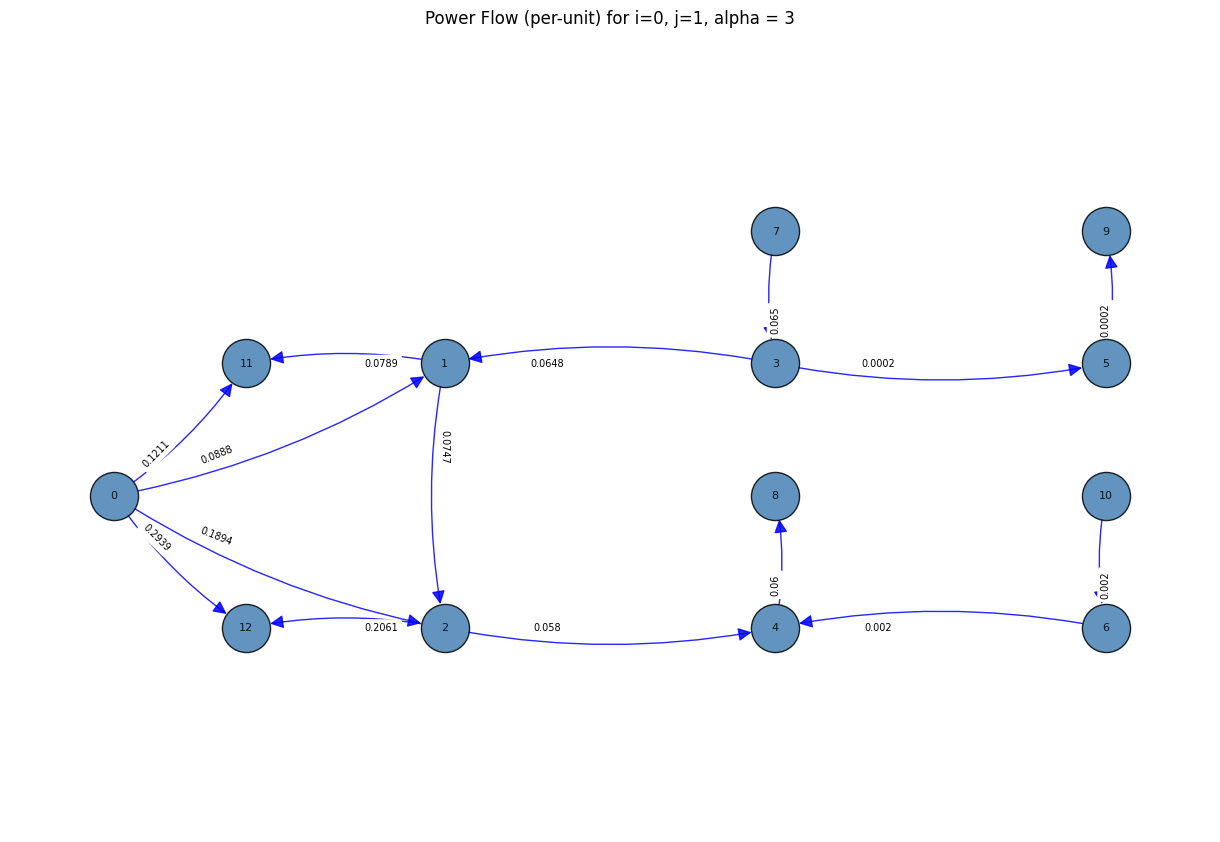

In [396]:
def plot_power_flow(m, i, j):
    pos = nx.get_node_attributes(G, 'pos')
    # Use node indices as labels
    labels = {n: n for n in G.nodes()}

    plt.figure(figsize=(12, 8))

    edge_colors = []
    edge_labels = {}
    # Create a list of edges with direction based on flow
    directed_edges = []


    for u, v in G.edges():
        try:
            # Get the flow value from the model
            flow_value = m.F[u, v, i, j].value
            if flow_value is not None:
                edge_labels[(u, v)] = f"{round(abs(flow_value), 4)}" # Display absolute value
                if flow_value > 0:
                    edge_colors.append('blue')  # Positive flow (u to v) - Blue arrow
                    directed_edges.append((u, v)) # Arrow from u to v
                elif flow_value < 0:
                    edge_colors.append('blue')  # Negative flow (v to u) - Still blue, but direction will be reversed
                    directed_edges.append((v, u)) # Arrow from v to u (reverse direction)
                else:
                    edge_colors.append('gray') # No flow
                    directed_edges.append((u, v)) # Still add edge for drawing, no specific direction
            else:
                edge_colors.append('gray') # No flow value
                directed_edges.append((u, v)) # Still add edge for drawing, no specific direction
        except Exception as e: # Catching the exception
            print(f"Error processing edge ({u}, {v}): {e}")
            edge_colors.append('gray') # Handle cases where edge might not be in m.F
            directed_edges.append((u, v)) # Still add edge for drawing, no specific direction


    # Create a directed graph for drawing purposes with correct edge directions
    draw_graph = nx.DiGraph()
    draw_graph.add_nodes_from(G.nodes(data=True))
    draw_graph.add_edges_from(directed_edges)

    # Draw the network
    nx.draw(
        draw_graph, pos,
        with_labels=True, labels=labels, # Draw labels with node indices
        node_size=1200,
        edge_color=edge_colors, # Use the calculated edge colors (now always blue or gray for non-zero flow)
        edgecolors="black", font_size=8,
        alpha=0.85,
        node_color='steelblue', # Default node color
        arrows=True, arrowsize=20, # Enable arrows and set size
        connectionstyle='arc3,rad=0.1' # Add some curvature to distinguish directions if needed
    )


    nx.draw_networkx_edge_labels(draw_graph, pos, edge_labels=edge_labels, font_size=7, label_pos=0.3) # Use draw_graph for edge labels

    plt.title(f"Power Flow (per-unit) for i={i}, j={j}, alpha = 3")
    plt.axis("equal")
    plt.show()

# Example usage (assuming m, i=0, and j=0 are defined)
plot_power_flow(m, 0, 1)

In [397]:
def create_network():

    import pandapower as pp

# Crée le réseau
    net = pp.create_empty_network()

# Bases
    Pbase = 100  # MVA
    Vbase_high = 110  # kV
    Vbase_medium = 20  # kV
    Vbase_low = 0.4  # kV

# Buses
    b0 = pp.create_bus(net, vn_kv=Vbase_high, name="Bus grid", geodata=(0,10))
    b1 = pp.create_bus(net, vn_kv=Vbase_high, name="DSO 1", geodata=(5,12))
    b2 = pp.create_bus(net, vn_kv=Vbase_high, name="DSO 2", geodata=(5,8))
    b3 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus MV_1", geodata=(10,12))
    b4 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus MV_2", geodata=(10,8))
    b5 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus LV_1", geodata=(15,12))
    b6 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus LV_2", geodata=(15,8))
    b7 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus éolien", geodata=(10,14))
    b8 = pp.create_bus(net, vn_kv=Vbase_medium, name="Bus industriel", geodata=(10,10))
    b9 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus load", geodata=(15,14))
    b10 = pp.create_bus(net, vn_kv=Vbase_low, name="Bus PV", geodata=(15,10))
    b11 = pp.create_bus(net, vn_kv=Vbase_high, name="TSO 1", geodata=(2,12))
    b12 = pp.create_bus(net, vn_kv=Vbase_high, name="TSO 2", geodata=(2,8))

# Lignes
    pp.create_line(net, b0, b1, length_km=12, std_type='149-AL1/24-ST1A 110.0', name="line1")
    pp.create_line(net, b1, b2, length_km=10, std_type='149-AL1/24-ST1A 110.0', name="line2")
    pp.create_line(net, b0, b2, length_km=10, std_type='149-AL1/24-ST1A 110.0', name="line3")
    pp.create_line(net, b3, b7, length_km=0.23, std_type='NA2XS2Y 1x185 RM/25 12/20 kV', name="line4")
    pp.create_line(net, b4, b8, length_km=0.3, std_type='NA2XS2Y 1x185 RM/25 12/20 kV', name="line5")
    pp.create_line(net, b5, b9, length_km=3, std_type='94-AL1/15-ST1A 0.4', name="line6")
    pp.create_line(net, b6, b10, length_km=0.45, std_type='94-AL1/15-ST1A 0.4', name="line7")
    pp.create_line(net, b0, b11, length_km=16, std_type='149-AL1/24-ST1A 110.0', name= 'line8')
    pp.create_line(net, b11, b1, length_km=24, std_type='149-AL1/24-ST1A 110.0', name= 'line9')
    pp.create_line(net, b0, b12, length_km=22, std_type='149-AL1/24-ST1A 110.0', name= 'line10')
    pp.create_line(net, b12, b2, length_km=16, std_type='149-AL1/24-ST1A 110.0', name= 'line11')

# Transformateurs
    pp.create_transformer(net, b1, b3, std_type="25 MVA 110/20 kV", name="TR_1")
    pp.create_transformer(net, b2, b4, std_type="25 MVA 110/20 kV", name="TR_2")
    pp.create_transformer(net, b3, b5, std_type="0.4 MVA 20/0.4 kV", name="TR_3")
    pp.create_transformer(net, b4, b6, std_type="0.4 MVA 20/0.4 kV", name="TR_4")

# Éléments de bus
    pp.create_ext_grid(net, bus=b0, vm_pu=1.00, name="Grid Connection")
    pp.create_load(net, bus=b9, p_mw=0.02, q_mvar=0.02, name="Residential Load")
    pp.create_gen(net, bus=b10, p_mw=0.2, vm_pu=1.00, name="PV", max_q_mvar=200, min_q_mvar=0, max_p_mw=300, min_p_mw=0, controllable=False)
    pp.create_gen(net, bus=b7, p_mw=6.5, vm_pu=1.0, name="Wind Turbine", controllable=False)
    pp.create_load(net, bus=b8, p_mw=6, q_mvar=1.8, name="Industry")
    pp.create_load(net, bus=b11, p_mw=20, q_mvar=9, name="Datacenter")
    pp.create_load(net, bus=b12, p_mw=50, q_mvar=24, name="Big industry")

# Donner accès à net
    return net

In [398]:
def create_digraph():
  net = create_network()

  import json
  import networkx as nx
  import matplotlib.pyplot as plt
# 1. Conversion du réseau Pandapower en DiGraph
# ================================
  G = nx.Graph()

# Créer les positions à partir de la colonne "geo"
  pos = {}
  for idx, row in net.bus.iterrows():
  # Extraire le champ 'geo' qui est une chaîne de caractères représentant un dictionnaire JSON
      geo_data = row['geo']

  # Convertir la chaîne JSON en un dictionnaire Python
      geo_dict = json.loads(geo_data)

  # Extraire la liste des coordonnées
      coordinates = geo_dict["coordinates"]

  # Ajouter les coordonnées dans le dictionnaire pos
      pos[idx] = tuple(coordinates)  # Assigner les coordonnées sous forme de tuple

# Ajouter les nœuds (avec le nom comme label) and voltage
  for idx, row in net.bus.iterrows():
      G.add_node(idx, label=row["name"], pos=pos[idx], vn_kv=row["vn_kv"])


# Ajouter les arêtes pour les lines
  for _, row in net.line.iterrows():
      G.add_edge(row["from_bus"], row["to_bus"], type="line", name=row["name"], length=row["length_km"], std_type=row["std_type"])

# Ajouter les arêtes pour les transformateurs
  for _, row in net.trafo.iterrows():
      G.add_edge(row["hv_bus"], row["lv_bus"], type="trafo", name=row["name"], std_type = None)

# Ajouter les générateurs et les charges comme attributs aux nœuds
  for _, row in net.gen.iterrows():
      G.nodes[row["bus"]]["type"] = "gen"
      G.nodes[row["bus"]]["gen_name"] = row["name"]
      G.nodes[row["bus"]]["gen_power"] = row["p_mw"]

  for _, row in net.load.iterrows():
      G.nodes[row["bus"]]["type"] = "load"
      G.nodes[row["bus"]]["load_name"] = row["name"]
      G.nodes[row["bus"]]["load_power"] = row["p_mw"]

  for _, row in net.ext_grid.iterrows():
      G.nodes[row["bus"]]["type"] = "ext_grid"
      G.nodes[row["bus"]]["grid_name"] = row["name"]

# 2. Ajout des puissances consommées et injectées aux nœuds
# ================================
  nx.set_node_attributes(G, 0.0, "P_load")
  nx.set_node_attributes(G, 0.0, "P_gen")

# Charges
  for _, row in net.load.iterrows():
      G.nodes[row["bus"]]["P_load"] += row["p_mw"]
      print(row)

# Générateurs
  for _, row in net.gen.iterrows():
      G.nodes[row["bus"]]["P_gen"] += row["p_mw"]

# Source externe
  for _, row in net.ext_grid.iterrows():
      G.nodes[row["bus"]]["P_gen"] += 0

# Calculate P_net
  for n in G.nodes:
      G.nodes[n]["P_net"] = G.nodes[n]["P_gen"] - G.nodes[n]["P_load"]

# Create subnetworks (NetworkX DiGraphs) from the main graph G
  network1_buses = [0, 1, 2, 11,12]
  network2_buses = [3, 7, 5, 9, 10]
  network3_buses = [4, 8, 6]

# Assign G1 to G and then add power attributes to nodes in G
  G = G.subgraph(network1_buses)

  for n in G.nodes:
      G.nodes[n]["P"] = G.nodes[n]["P_net"] # Assign P_net to 'P' attribute

# 3. Préparer les couleurs des nœuds en fonction de P_net
# ================================
  node_colors = []
  for n, data in G.nodes(data=True):
      if data["P_net"] > 0:
          node_colors.append("green")   # producteur
      elif data["P_net"] < 0:
          node_colors.append("red")     # consommateur
      else:
          node_colors.append("gray")    # neutre

# 4. Préparer les labels : Nom + P_net
# ================================
  labels = {n: f"{data['label']}\nP={round(data['P_net'],2)}MW"
            for n, data in G.nodes(data=True)}

# 5. Function to plot the network
# ================================
  def plot_network():
      pos = nx.get_node_attributes(G, 'pos')

      plt.figure(figsize=(12, 8))
      nx.draw(
          G, pos,
          with_labels=True, labels=labels,
          node_size=1200, node_color=node_colors,
          edgecolors="black", font_size=8,
          alpha=0.85
          )

  # Labels des arêtes (type ligne ou trafo)
      edge_labels = nx.get_edge_attributes(G, 'type')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

      plt.title("Réseau électrique avec puissances (P_net)")
      plt.axis("equal")
      plt.show()


  return G, plot_network()

name               Residential Load
bus                               9
p_mw                           0.02
q_mvar                         0.02
const_z_percent                 0.0
const_i_percent                 0.0
sn_mva                          NaN
scaling                         1.0
in_service                     True
type                            wye
Name: 0, dtype: object
name               Industry
bus                       8
p_mw                    6.0
q_mvar                  1.8
const_z_percent         0.0
const_i_percent         0.0
sn_mva                  NaN
scaling                 1.0
in_service             True
type                    wye
Name: 1, dtype: object
name               Datacenter
bus                        11
p_mw                     20.0
q_mvar                    9.0
const_z_percent           0.0
const_i_percent           0.0
sn_mva                    NaN
scaling                   1.0
in_service               True
type                      wye
Name: 2, dtype

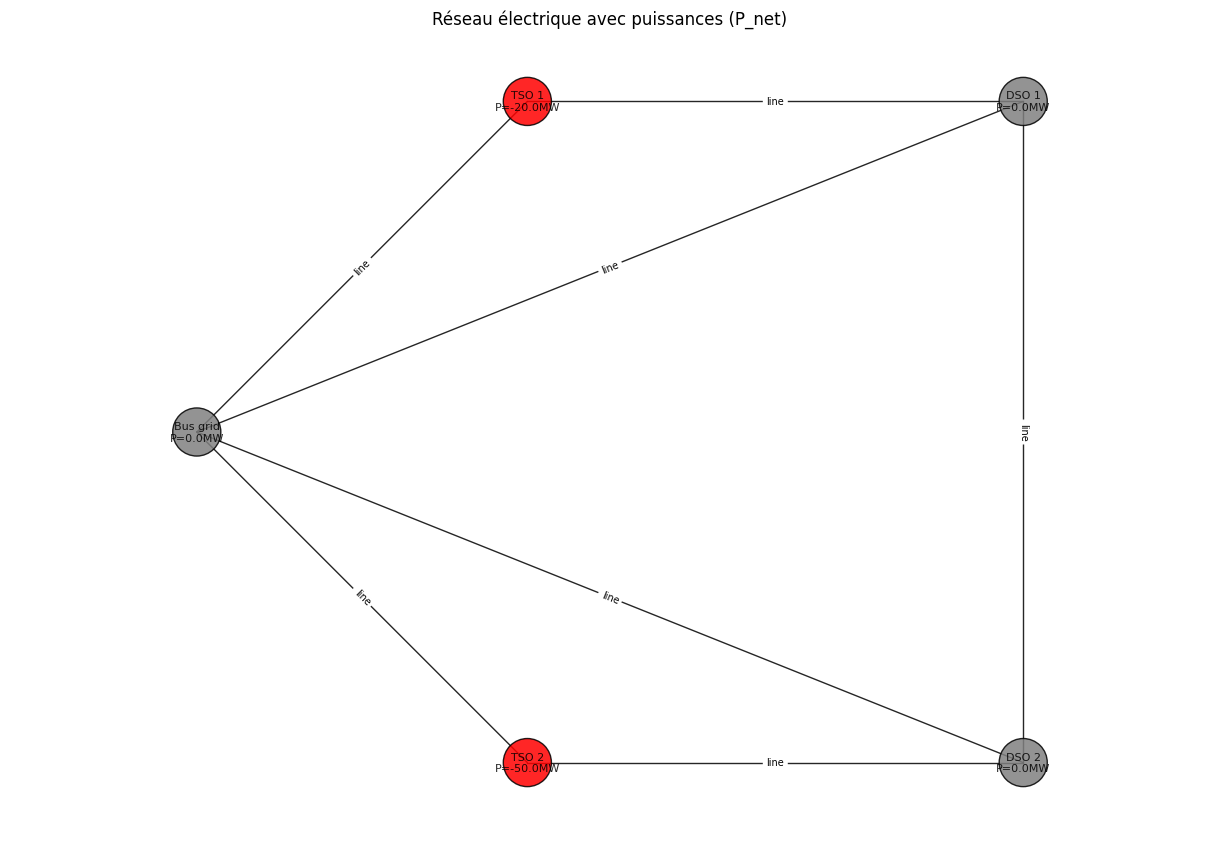

In [399]:
G, plot_func = create_digraph()

In [400]:
#Calculate the susceptance of each line in Siemens per km
strange = 1000
for u, v in G.edges():
    G[u][v]['b'] = length(u,v)* 200*10**-6 *strange
    print(G[u][v]['b'])

0.010770329614269008
0.010770329614269008
0.005656854249492381
0.005656854249492381
0.008
0.006
0.006


In [401]:
# Convert susceptance 'b' on edges to per-unit
for u, v in G.edges():
    # Assuming 'b' is in Siemens/km, convert to per-unit
    # b_pu = b_actual * (V_base^2 / S_base)
    # V_base is assumed to be v_base_high (110 kV)
    G[u][v]['b_pu'] = G[u][v].get('b', 0.0) * (get_base_node_voltage_kv(u)**2 / s_base)
    print(G[u][v]['b_pu'])

1.30320988332655
1.30320988332655
0.6844793641885781
0.6844793641885781
0.968
0.726
0.726


In [402]:
m = pyo.ConcreteModel()
# Define base values for the per-unit system
s_base = 100  # MVA
v_base_high = 110 # kV (From the create_network function)

m.Nodes = pyo.Set(initialize= [b for b in G.nodes])
m.Lines = pyo.Set(initialize= [l for l in G.edges])
m.i = pyo.Set(initialize=[0, 1]) # Initialize m.i with two generic elements
m.j = pyo.Set(initialize= [0, 1])
m.children = pyo.Set(initialize= [1, 2])
m.parents = pyo.Set(initialize = [0])

m.P = pyo.Param(m.Nodes, initialize = {n: - G.nodes[n].get('P') for n in G.nodes}, domain = pyo.Reals, mutable=True) # Make P mutable
m.P_absolute_value = pyo.Param(m.Nodes, initialize = {n: abs(m.P[n]) for n in G.nodes}, domain = pyo.NonNegativeReals) # Make P mutable

m.info_DSO_param = pyo.Param(m.children, initialize = {n: info_DSO[n-1] for n in m.children}, domain = pyo.Reals) # Renamed parameter and adjusted index for list

m.I_min = pyo.Param(m.Lines, initialize = {(i,j): calculate_current_bounds(G.edges[i,j]["std_type"], get_base_node_voltage_kv(i))[0] for (i,j) in m.Lines}, domain = pyo.Reals)
m.I_max = pyo.Param(m.Lines, initialize = {(i,j): calculate_current_bounds(G.edges[i,j]["std_type"], get_base_node_voltage_kv(i))[1] for (i,j) in m.Lines}, domain = pyo.Reals)

print(m.I_min[(0,1)])
print(m.I_max[(0,1)])

# Variables principales
m.F = pyo.Var(m.Lines, m.i, m.j, domain=pyo.Reals)     # active power flow through lines
m.I = pyo.Var(m.Lines,  m.i, m.j, domain=pyo.Reals)  # current flowing through lines
m.theta = pyo.Var(m.Nodes,  m.i, m.j, domain=pyo.Reals)  # phase angle of the voltage
m.V = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.NonNegativeReals)  # voltage magnitude at each node
m.E = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.Reals) #net power injection/consumption
m.P_plus = pyo.Var(m.parents, m.i, m.j, domain=pyo.Reals) #power entering the operational graph
m.P_minus = pyo.Var(m.children, m.i, m.j, domain=pyo.Reals) #power leaving the operational graph

m.P_C_set = pyo.Var(m.children, m.i, domain=pyo.Reals) #vertices of the power envelope at each child node

#m.P_C_min = pyo.Var(m.children, m.i, m.j, domain=pyo.Reals)
#m.P_C_max = pyo.Var(m.children, m.i, m.j,  domain=pyo.Reals)

m.V_P = pyo.Param(m.j, initialize = {0: 0.9, 1: 1.1}, domain =pyo.NonNegativeReals)

m.O = pyo.Var(domain= pyo.NonNegativeReals)
m.tot = pyo.Var(domain= pyo.Reals)
m.aux = pyo.Var(m.children, domain=pyo.Reals)
m.diff_DSO = pyo.Var(m.children, domain=pyo.NonNegativeReals)

for u in G.nodes():
  if G.nodes[u].get('P', 0.0) / s_base == 0:
    m.P[u] = 0
  else:
    G.nodes[u]['P_pu'] = G.nodes[u].get('P', 0.0) / s_base
    m.P[u] = - G.nodes[u]['P_pu']

"""# Convert P parameter to per-unit
for n in G.nodes:
    # Assuming P is in MW, convert to per-unit
    G.nodes[n]['P'] = G.nodes[n].get('P', 0.0) / s_base
    m.P[n] = G.nodes[n]['P']"""


# Convert susceptance 'b' on edges to per-unit
for u, v in G.edges():
    # Assuming 'b' is in Siemens/km, convert to per-unit
    # b_pu = b_actual * (V_base^2 / S_base)
    # V_base is assumed to be v_base_high (110 kV)
    G[u][v]['b_pu'] = G[u][v].get('b', 0.0) * (get_base_node_voltage_kv(u)**2 / s_base)

    print(G[u][v]['b_pu'])

-0.8954702675131095
0.8954702675131095
1.30320988332655
1.30320988332655
0.6844793641885781
0.6844793641885781
0.968
0.726
0.726


In [403]:
for n in G.nodes:
  print(m.P[n].value)
m.P[1].value


0
0
0
0.2
0.5


0

In [404]:
#Children nodes consumption
def worst_case_children(m, n, vert_pow, vert_volt):
  return m.P_C_set[n, vert_pow] == m.P_minus[n, vert_pow, vert_volt]
m.worst_case = pyo.Constraint(m.children, m.i, m.j, rule=worst_case_children)


# Auxiliary variable for the absolute value of E (already defined as per-unit)
m.z = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.NonNegativeReals)

m.curt = pyo.Var(m.Nodes, m.i, m.j, domain=pyo.Reals)

def curtailment_def_rule(m,n, vert_pow, vert_volt):

  return m.curt[n, vert_pow, vert_volt] == m.P[n] - m.E[n, vert_pow, vert_volt]

m.curt_def = pyo.Constraint(m.Nodes, m.i, m.j, rule=curtailment_def_rule)
# Constraints to define the absolute value (already defined for per-unit E)
def abs_E_pos_rule(m, n, vert_pow, vert_volt):
    return m.z[n, vert_pow, vert_volt] >= m.curt[n, vert_pow, vert_volt]
m.abs_E_pos = pyo.Constraint(m.Nodes, m.i, m.j, rule=abs_E_pos_rule)

def abs_E_neg_rule(m, n, vert_pow, vert_volt):
    return m.z[n, vert_pow, vert_volt] >= -m.curt[n, vert_pow, vert_volt]
m.abs_E_neg = pyo.Constraint(m.Nodes, m.i, m.j, rule=abs_E_neg_rule)

def upper_bound_rule(m, vert_pow, vert_volt):
    # m.z is per-unit, m.O is per-unit
    return sum(m.z[n, vert_pow, vert_volt] for n in m.Nodes) <= m.O

m.upper_bound = pyo.Constraint(m.i, m.j, rule=upper_bound_rule)

# Current magnitude constraint (I_min, I_max are assumed per-unit)
def current_bounds_rule(m, i, j, vert_pow, vert_volt):
    # m.I is per-unit current
    return pyo.inequality(m.I_min[(i,j)], m.I[i,j, vert_pow, vert_volt], m.I_max[(i,j)])
m.CurrentBounds = pyo.Constraint(m.Lines, m.i, m.j, rule=current_bounds_rule)

def phase_constr_rule(m,n, vert_pow, vert_volt):
    return pyo.inequality(theta_min/10, m.theta[n, vert_pow, vert_volt], theta_max/10)

m.phaseConstr = pyo.Constraint(m.Nodes, m.i, m.j, rule=phase_constr_rule)

def dc_power_flow_rule(m, i, j, vert_pow, vert_volt):
    return m.F[i, j, vert_pow, vert_volt] == m.V_P[vert_volt]**2 *(G[i][j]['b_pu'] * (
        m.theta[i, vert_pow, vert_volt] - m.theta[j, vert_pow, vert_volt])
    )

m.DCFlow = pyo.Constraint(m.Lines, m.i, m.j, rule=dc_power_flow_rule)


def current_def_rule(m, n, i, j, vert_pow, vert_volt):
    # This constraint relates per-unit current, per-unit voltage, and per-unit power flow.
    # In per-unit, P_pu = V_pu * I_pu. This is correct.
    return m.I[i,j, vert_pow, vert_volt] * m.V_P[vert_volt] == m.F[i,j, vert_pow, vert_volt]

m.current_def = pyo.Constraint(m.Nodes, m.Lines, m.i, m.j, rule=current_def_rule)



"""def nodes_balance(m, n, vert_pow, vert_volt):
    inflow = sum(m.F[k, n, vert_pow, vert_volt] for k in G.predecessors(n) if (k, n) in m.Lines)
    outflow = sum(m.F[n, j, vert_pow, vert_volt] for j in G.successors(n) if (n, j) in m.Lines)
    if n in m.parents:
      return inflow - outflow  ==  m.E[n, vert_pow, vert_volt] - m.P_plus[n, vert_pow, vert_volt]

    if n in m.children:
      return inflow - outflow  ==  m.E[n, vert_pow, vert_volt] + m.P_minus[n, vert_pow, vert_volt]

    else:
      return inflow - outflow ==  m.E[n,vert_pow,vert_volt]

m.nodes_balance = pyo.Constraint(m.Nodes, m.i, m.j, rule=nodes_balance)"""

def power_balance_rule(m, n, vert_pow, vert_volt):
    # Compute net flow into node n by summing over all lines (i,j) in m.Lines
    expr = sum(
        (m.F[i, j, vert_pow, vert_volt] if j == n else 0)
      - (m.F[i, j, vert_pow, vert_volt] if i == n else 0)
      for (i, j) in m.Lines
    )
    # If n is a parent node, subtract P_plus; otherwise use only E[n]
    if n in m.parents:
      return expr == m.E[n, vert_pow, vert_volt] - m.P_plus[n, vert_pow, vert_volt]

    if n in m.children:
      return expr ==  m.E[n, vert_pow, vert_volt] + m.P_minus[n, vert_pow, vert_volt]
    else:
      return expr == m.E[n, vert_pow, vert_volt]

m.power_balance = pyo.Constraint(m.Nodes, m.i, m.j, rule=power_balance_rule)

def parent_power_constraint_rule(m, parent, vert_pow, vert_volt):
    # m.P_plus is per-unit power entering the operational graph
    return pyo.inequality(-1, m.P_plus[parent, vert_pow, vert_volt],1)

m.parent_power_constraint = pyo.Constraint(m.parents, m.i, m.j, rule=parent_power_constraint_rule)


#Constant voltage assumption
def voltage_constr_rule(m, n, vert_pow, vert_volt):
    return m.V[n, vert_pow, vert_volt] == m.V_P[vert_volt]

m.voltageConstr = pyo.Constraint(m.Nodes, m.i, m.j, rule=voltage_constr_rule)

def children_voltage_rule(m, children, vert_pow, vert_volt):
    return pyo.inequality(V_min, m.V[children, vert_pow, vert_volt], V_max)

m.children_voltage = pyo.Constraint(m.children, m.i, m.j, rule=children_voltage_rule)



def aux_constraint_rule(m, n):
  return m.aux[n] == m.P_C_set[n, 0] - m.P_C_set[n, 1]
m.aux_constraint = pyo.Constraint(m.children, rule=aux_constraint_rule)

def logical_constraint_rule(m, n):
  return m.P_C_set[n, 0] >= m.P_C_set[n, 1]
m.logical_constraint = pyo.Constraint(m.children, rule=logical_constraint_rule)

"""def info_DSO_min_rule(m,n):
  return m.P_C_set[n,1] <= m.info_DSO_param[n]
m.info_DSO_min = pyo.Constraint(m.children, rule=info_DSO_min_rule)

def info_DSO_max_rule(m,n):
  return m.P_C_set[n,0] >= m.info_DSO_param[n]
m.info_DSO_max = pyo.Constraint(m.children, rule=info_DSO_max_rule)"""

def tot_rule(m):
  return m.tot == sum(m.aux[n] for n in m.children)
m.tot_constraint = pyo.Constraint(rule=tot_rule)

def diff_DSO_rule(m,n):
  return - m.diff_DSO[n] <= (m.P_C_set[n,0] + m.P_C_set[n,1])/2 - m.info_DSO_param[n]
m.diff_DSO_constraint = pyo.Constraint(m.children, rule=diff_DSO_rule)

def diff_bis_dso_rule(m,n):
  return (m.P_C_set[n,0] + m.P_C_set[n,1])/2 - m.info_DSO_param[n] <= m.diff_DSO[n]
m.diff_bis_dso_constraint = pyo.Constraint(m.children, rule=diff_bis_dso_rule)


m.abs_diff_DSO = pyo.Var(m.children, domain=pyo.NonNegativeReals)
"""def abs_different_rule(m, n):
    return  m.abs_diff_DSO[n] >= -m.diff_DSO[n]
m.abs_different = pyo.Constraint(m.children, rule=abs_different_rule)

def abs_different_bis_rule(m, n):
    return  m.abs_diff_DSO[n] >= m.diff_DSO[n]
m.abs_different = pyo.Constraint(m.children, rule=abs_different_rule)"""

m.tot_bis = pyo.Var(domain=pyo.Reals)
def tot_bis_rule(m):
  return m.tot_bis == sum(m.diff_DSO[n] for n in m.children)
m.tot_bis_constraint = pyo.Constraint(rule=tot_bis_rule)

def net_power_constr_rule(m,n, vert_pow, vert_volt):
  return pyo.inequality(- m.P_absolute_value[n], m.E[n, vert_pow, vert_volt], m.P_absolute_value[n])

m.net_power_constr = pyo.Constraint(m.Nodes, m.i, m.j, rule=net_power_constr_rule)


"""# Auxiliary variables for the L1 norm of P_C_set
m.abs_P_C_set = pyo.Var(m.children, domain=pyo.NonNegativeReals)

# Constraints to linearize the L1 norm of P_C_set
def abs_P_C_set_pos_rule(m, n):
    return m.abs_P_C_set[n] >= m.aux[n]
m.abs_P_C_set_pos = pyo.Constraint(m.children, rule=abs_P_C_set_pos_rule)

def abs_P_C_set_neg_rule(m, n):
    return m.abs_P_C_set[n] >= -m.aux[n]
m.abs_P_C_set_neg = pyo.Constraint(m.children, rule=abs_P_C_set_neg_rule)"""

'# Auxiliary variables for the L1 norm of P_C_set\nm.abs_P_C_set = pyo.Var(m.children, domain=pyo.NonNegativeReals)\n\n# Constraints to linearize the L1 norm of P_C_set\ndef abs_P_C_set_pos_rule(m, n):\n    return m.abs_P_C_set[n] >= m.aux[n]\nm.abs_P_C_set_pos = pyo.Constraint(m.children, rule=abs_P_C_set_pos_rule)\n\ndef abs_P_C_set_neg_rule(m, n):\n    return m.abs_P_C_set[n] >= -m.aux[n]\nm.abs_P_C_set_neg = pyo.Constraint(m.children, rule=abs_P_C_set_neg_rule)'

In [405]:
A = [0.5,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,2,2.05,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.1,3.2]
#A = range(-3, 26)
beta = 1
enveloppe_taille = []
curtail = []
close = []

for alpha in A:
  val = 0
  print(alpha)
  print(m.P_C_set[1,0].value)
  print(m.P_C_set[1,1].value)

  print(m.P_C_set[2,0].value)
  print(m.P_C_set[2,1].value)
  def objective_rule(m):
    return  m.tot - alpha*m.O - beta * m.tot_bis
  m.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)
  params = {
    "WLSACCESSID": 'efa10779-150a-495c-ab62-6a20ff44c598',
    "WLSSECRET": 'fa980d94-a6fd-4d7b-aa68-b0e19ddd2e84',
    "LICENSEID": 2651433,
           }
  env = gp.Env(params=params)
  solver = pyo.SolverFactory('gurobi', env= env)
  results = solver.solve(m, tee=True)

  # Check the termination condition before accessing results
  if results.solver.termination_condition == pyo.TerminationCondition.optimal:
      val = sum(abs(m.P_C_set[n,0].value) + abs(m.P_C_set[n,1].value) for n in m.children)
      # Append optimal results to lists
      curtail.append(m.O.value)
      enveloppe_taille.append(m.tot.value)
      close.append(m.tot_bis.value)

  else:
      # Append None for non-optimal results to maintain list length
      curtail.append(None)
      enveloppe_taille.append(None)
      close.append(None)

0.5
None
None
None
None
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpwbu4ylc5.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x7c76ef03
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
      

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1
1.530104120315606
-1.659704120315606
1.6155585246877688
-1.4995585246877692
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpz8pb0b6w.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x0b5a1701
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Obj

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.1
1.4822464815235972
-1.611846481523597
1.626136554853152
-1.611846481523597
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpxlkn7j2s.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xf18adfc7
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Ob

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.2
1.4822464815235972
-1.611846481523597
1.626136554853153
-1.611846481523597
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpeo18oqdc.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xbb27877c
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Ob

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.3
1.4822464815235972
-1.611846481523597
1.626136554853153
-1.611846481523597
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpcmdjv5mr.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xf161c9dd
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Ob

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.4
1.4822464815235972
-1.611846481523597
1.626136554853153
-1.611846481523597
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpmookgtfg.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xef556d24
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Ob

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
1.4822464815235972
-1.611846481523597
1.626136554853153
-1.611846481523597
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpx4apcm81.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xf1159dee
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Ob

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpvp8gqeor.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xabd04381
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00   3.

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.7
0.825864057825354
-1.611846481523597
1.0590626128954934
-1.611846481523597
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpr369al4s.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x9023cc12
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Ob

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.8
0.825864057825354
-1.611846481523597
1.0590626128954934
-1.611846481523597
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpr1aiminz.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xdbef0522
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.01s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Ob

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.9
1.417298326623746
-1.546898326623746
0.34144648152360735
-1.611846481523597
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp5wqqa3u8.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xb6ac6ad1
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    O

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.95
1.417298326623746
-1.546898326623746
0.34144648152360735
-1.611846481523597
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp78iufjdd.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x47369c22
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2
1.417298326623746
-1.546898326623746
0.34144648152360735
-1.611846481523597
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpfxstpsmf.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xfc9f978c
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Obj

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.05
1.3181033908942634
-1.611846481523597
0.4406414172530795
-1.546898326623746
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp46r0rvs9.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xe47ac68b
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.1
0.45934041211806864
-1.5406595878819334
-0.1593404121180665
-0.1593404121180665
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmptleqiepi.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xef978938
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.2
0.45934041211806864
-1.5406595878819334
-0.1593404121180665
-0.1593404121180665
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpm7wmmteq.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xb31b158e
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.3
0.45934041211806864
-1.5406595878819334
-0.1593404121180665
-0.1593404121180665
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpr3kftm8q.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x30072c98
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpinhu922z.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x03b73404
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00   3.

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmph_vz_mnn.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x52f587f7
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00   3.

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.6
0.45934041211806864
-1.5406595878819334
-0.1593404121180665
-0.1593404121180665
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp7lac77ia.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x8a2a9112
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp92dgd2ke.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xd2487cf2
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00   3.

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.8
0.45934041211806864
-1.5406595878819334
-0.1593404121180665
-0.1593404121180665
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp89oa3jyr.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xb9b5fd9c
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2.9
0.45934041211806864
-1.5406595878819334
-0.1593404121180665
-0.1593404121180665
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp52px2kp4.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x1ff603ba
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


3
0.45934041211806864
-1.5406595878819334
-0.1593404121180665
-0.1593404121180665
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpv28eapd1.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xe91b3c80
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration   

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


3.1
0.45934041211806864
-1.5406595878819334
-0.1593404121180665
-0.1593404121180665
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpz3ziaoe5.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xdbc473c1
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



0.45934041211806864
-1.5406595878819334
-0.1593404121180665
-0.1593404121180665
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpr8gnf2lo.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xca6155b0
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    

In [406]:
print(enveloppe_taille)
print(curtail)
print(close)

[6.30492529000675, 6.332075999423943, 6.332075999423944, 6.332075999423944, 6.332075999423944, 6.332075999423944, 5.394662409934617, 5.108619633768042, 5.108619633768042, 4.917489616294697, 4.917489616294697, 4.917489616294697, 4.917489616294686, 2.0000000000000018, 2.0000000000000018, 2.0000000000000018, 2.0000000000000018, 2.0000000000000018, 2.0000000000000018, 2.0000000000000018, 2.0000000000000018, 2.0000000000000018, 2.0000000000000018, 2.0000000000000018, 2.0000000000000018, 2.0000000000000018]
[2.845662645003374, 2.8083830363767497, 2.80838303637675, 2.80838303637675, 2.80838303637675, 2.80838303637675, 1.8709694468874245, 1.5849266707208456, 1.5849266707208456, 1.458744808147343, 1.458744808147343, 1.458744808147343, 1.458744808147343, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.05085496333522255, 0.05085496333522199, 0.05085496333522199, 0.05085496333522199, 0.05085496333522199, 0.5195617580798856, 0.6625831461631734, 0.6625831461631734, 0.6931999

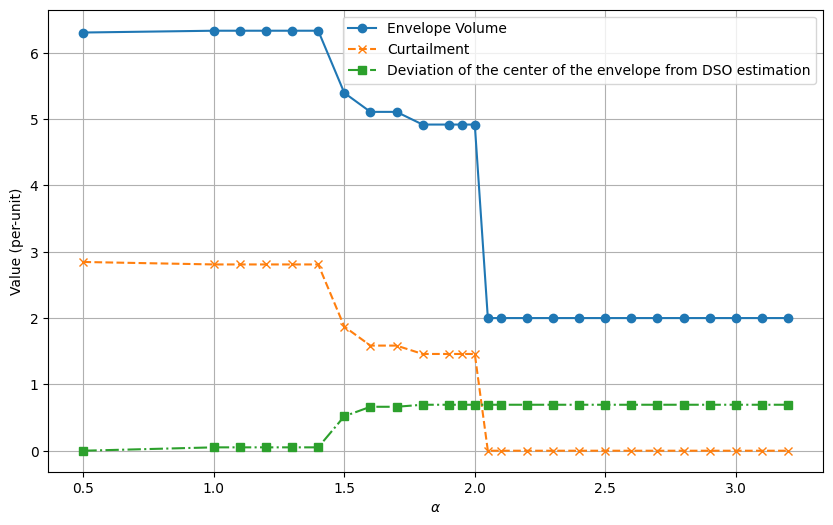

In [407]:
# Convert A to a numpy array for easier plotting
alpha_values = np.array(A)

# Convert lists to numpy arrays, replacing None with NaN for plotting
enveloppe_taille_np = np.array(enveloppe_taille, dtype=float)
curtail_np = np.array(curtail, dtype=float)
close_np = np.array(close, dtype=float)


plt.figure(figsize=(10, 6))

# Plot enveloppe_taille vs alpha
plt.plot(alpha_values, enveloppe_taille_np, marker='o', linestyle='-', label='Envelope Volume')

# Plot curtail vs alpha
plt.plot(alpha_values, curtail_np, marker='x', linestyle='--', label='Curtailment')

# Plot close vs alpha
plt.plot(alpha_values, close_np, marker='s', linestyle='-.', label='Deviation of the center of the envelope from DSO estimation')


# Set x-axis to a logarithmic scale
#plt.xscale('log')

plt.xlabel('$\\alpha$')
plt.ylabel('Value (per-unit)')
#plt.title(f'Evolution of the volume of the envelope, curtailment and closeness to DSO estimation as a function of parameter Alpha (beta={beta})')
plt.legend()
plt.grid(True)

# Save the plot as a PDF file
plt.savefig('DOE_alloc_alpha.pdf')

plt.show()

In [408]:
for n in m.Nodes:
  for vert_pow in m.i:
    for vert_volt in m.j:
      print(f"m.E[{n},{vert_pow},{vert_volt}].value: {m.E[n,vert_pow,vert_volt].value}")

m.E[0,0,0].value: 0.0
m.E[0,0,1].value: 0.0
m.E[0,1,0].value: 0.0
m.E[0,1,1].value: 0.0
m.E[1,0,0].value: 0.0
m.E[1,0,1].value: 0.0
m.E[1,1,0].value: 0.0
m.E[1,1,1].value: 0.0
m.E[2,0,0].value: 0.0
m.E[2,0,1].value: 0.0
m.E[2,1,0].value: 0.0
m.E[2,1,1].value: 0.0
m.E[11,0,0].value: 0.2
m.E[11,0,1].value: 0.2
m.E[11,1,0].value: 0.2
m.E[11,1,1].value: 0.2
m.E[12,0,0].value: 0.5
m.E[12,0,1].value: 0.5
m.E[12,1,0].value: 0.5
m.E[12,1,1].value: 0.5


In [351]:
m.O.value

0.0

In [352]:
print(m.F[0,11,0,0].value)
print(m.F[0,11,0,1].value)

0.1900875438604242
0.19008754386042448


In [409]:
print(m.P_C_set[1,0].value)
print(m.P_C_set[1,1].value)

print(m.P_C_set[2,0].value)
print(m.P_C_set[2,1].value)

0.45934041211806864
-1.5406595878819334
-0.1593404121180665
-0.1593404121180665


In [410]:
print(m.theta[0,0,0].value)
print(m.theta[0,0,1].value)

print(m.theta[11,0,0].value)
print(m.theta[11,0,1].value)

-17.476705310014484
-17.64969529017499
-17.819558568056525
-17.87920862820313


In [411]:

m.O.value


0.0

In [412]:
m.aux[1].value

2.0000000000000018

In [413]:
m.P_C_set[1,0].value

0.45934041211806864

In [414]:
m.P_C_set[1,1].value

-1.5406595878819334

In [315]:
m.aux[2].value

0.43468082423608734

In [359]:
m.P[0].value

0

In [360]:
m.P_plus[0,0,1].value

0.9999999999999886

In [318]:
m.P_minus[1,0,1].value

0.024659587881951245

In [319]:
m.P_C_set[2,0].value

0.27534041211804366

In [320]:
m.P_C_set[1,1].value

-1.5406595878819291

In [321]:
for (u,v) in m.Lines:
  print((u,v))

(0, 1)
(0, 2)
(0, 11)
(0, 12)
(1, 2)
(11, 1)
(12, 2)


In [361]:
# Corrected loop structure to iterate over m.Lines
for (u, v) in m.Lines:
  for vert_pow in m.i:
    for vert_volt in m.j:
      print(f"Flow on line ({u}, {v}) for i={vert_pow}, j={vert_volt}: {m.F[u, v, vert_pow, vert_volt].value}")

Flow on line (0, 1) for i=0, j=0: 0.344122497754622
Flow on line (0, 1) for i=0, j=1: 0.3441224977546149
Flow on line (0, 1) for i=1, j=0: -0.8059232407617986
Flow on line (0, 1) for i=1, j=1: -0.8059232407617962
Flow on line (0, 2) for i=0, j=0: 0.17566058087047848
Flow on line (0, 2) for i=0, j=1: 0.17566058087047054
Flow on line (0, 2) for i=1, j=0: -0.24867104581043795
Flow on line (0, 2) for i=1, j=1: -0.24867104581043975
Flow on line (0, 11) for i=0, j=0: 0.1900875438604242
Flow on line (0, 11) for i=0, j=1: 0.19008754386042448
Flow on line (0, 11) for i=1, j=0: -0.1208198079545477
Flow on line (0, 11) for i=1, j=1: -0.12081980795454705
Flow on line (0, 12) for i=0, j=0: 0.29012937751447787
Flow on line (0, 12) for i=0, j=1: 0.29012937751447865
Flow on line (0, 12) for i=1, j=0: 0.17541409452678422
Flow on line (0, 12) for i=1, j=1: 0.1754140945267828
Flow on line (1, 2) for i=0, j=0: -0.12513037050302245
Flow on line (1, 2) for i=0, j=1: -0.12513037050302295
Flow on line (1, 2) 

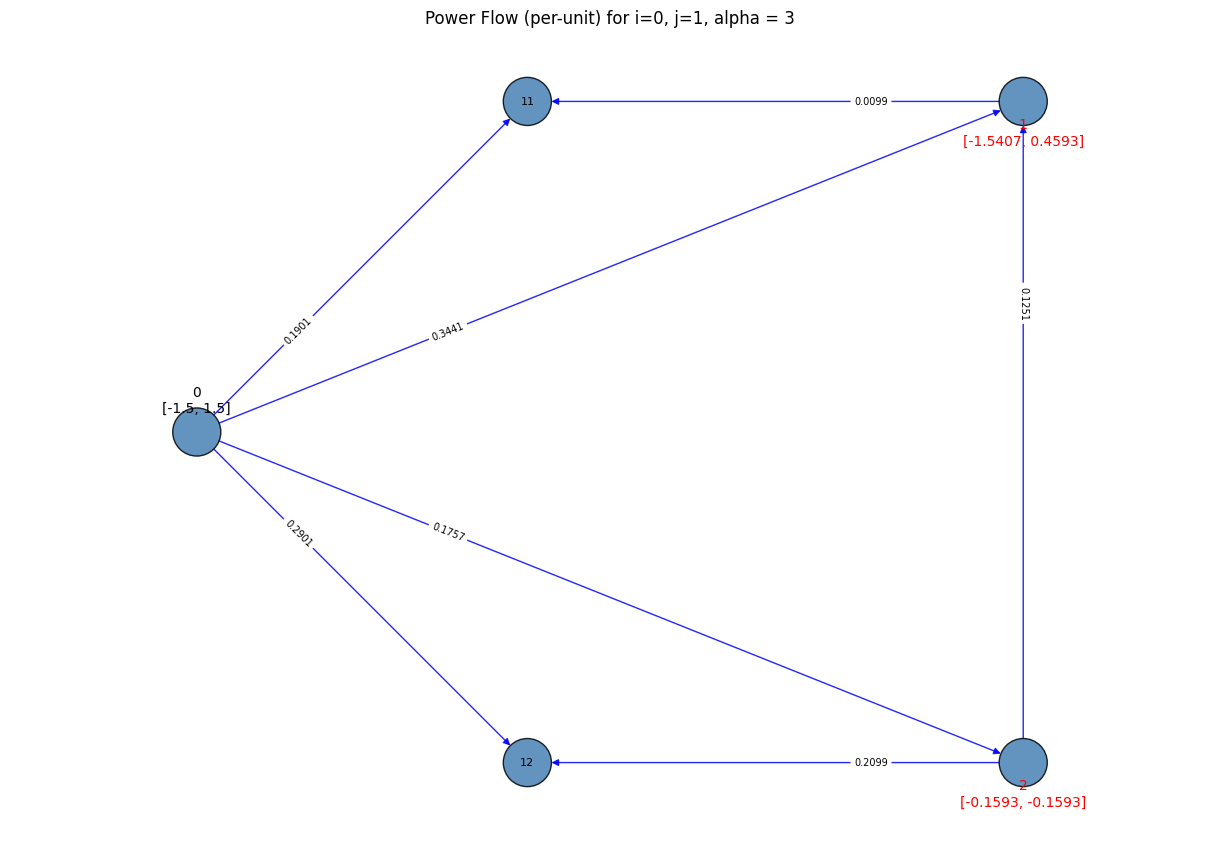

In [363]:
def plot_power_flow(m, i, j):
    pos = nx.get_node_attributes(G, 'pos')
    # Use node indices as labels
    labels = {}
    label_colors = [] # This is for node colors, will remove this later if needed or set to default
    # Use the defined children and parents sets from the model
    children_nodes_set = m.children
    parents_nodes_set = m.parents

    for n in G.nodes():
        label_text = f"{n}"
        if n in parents_nodes_set:
            # Display parent bounds using the global P_min and P_max parameters
            label_text += f"\n[{P_min}, {P_max}]"
            # No specific color for label text here, use default
            label_colors.append('steelblue') # Default node color based on previous plots
        elif n in children_nodes_set:
            # Display children interval with smaller value first
            # Access P_C_set values - assuming P_C_set is defined and indexed by children and i
            p_c_values = [m.P_C_set[n, 0].value, m.P_C_set[n, 1].value] # Assuming m.P_C_set is indexed by children and i
            label_text += f"\n[{round(min(p_c_values), 4)}, {round(max(p_c_values), 4)}]"
            # We will try to color this text red when drawing labels
            label_colors.append('steelblue') # Default node color
        else:
            label_colors.append('steelblue') # Default node color
        labels[n] = label_text


    plt.figure(figsize=(12, 8))

    edge_colors = []
    edge_labels = {}
    # Create a list of edges with direction based on flow
    directed_edges = []


    for u, v in G.edges():
        try:
            # Get the flow value from the model
            flow_value = m.F[u, v, i, j].value
            if flow_value is not None:
                edge_labels[(u, v)] = f"{round(abs(flow_value), 4)}" # Display absolute value
                if flow_value > 0:
                    edge_colors.append('blue')  # Positive flow (u to v) - Blue arrow
                    directed_edges.append((u, v)) # Arrow from u to v
                elif flow_value < 0:
                    edge_colors.append('blue')  # Negative flow (v to u) - Still blue, but direction will be reversed
                    directed_edges.append((v, u)) # Arrow from v to u (reverse direction)
                else:
                    edge_colors.append('gray') # No flow
                    directed_edges.append((u, v)) # Still add edge for drawing, no specific direction
            else:
                edge_colors.append('gray') # No flow value
                directed_edges.append((u, v)) # Still add edge for drawing, no specific direction
        except Exception as e: # Catching the exception
            print(f"Error processing edge ({u}, {v}): {e}")
            edge_colors.append('gray') # Handle cases where edge might not be in m.F
            directed_edges.append((u, v)) # Still add edge for drawing, no specific direction


    # Create a directed graph for drawing purposes with correct edge directions
    draw_graph = nx.DiGraph()
    draw_graph.add_nodes_from(G.nodes(data=True))
    draw_graph.add_edges_from(directed_edges)

    # Draw the network
    nx.draw(
        draw_graph, pos,
        with_labels=False, # Draw labels separately for color control
        node_size=1200,
        edge_color=edge_colors, # Use the calculated edge colors (now always blue or gray for non-zero flow)
        edgecolors="black", font_size=8,
        alpha=0.85,
        node_color = label_colors # Apply node colors
    )

    # Draw labels with different colors
    for n in G.nodes():
        x, y = pos[n]
        text = labels[n]
        if n in children_nodes_set:
            plt.text(x, y - 0.1, text, fontsize=10, ha='center', va='top', color='red') # Color children interval red
        elif n in parents_nodes_set:
             plt.text(x, y + 0.1, text, fontsize=10, ha='center', va='bottom', color='black') # Color parent bounds black
        else:
             plt.text(x, y, text, fontsize=8, ha='center', va='center', color='black') # Default color for other labels


    nx.draw_networkx_edge_labels(draw_graph, pos, edge_labels=edge_labels, font_size=7, label_pos=0.3) # Use draw_graph for edge labels

    plt.title(f"Power Flow (per-unit) for i={i}, j={j}, alpha = 3")
    plt.axis("equal")
    plt.show()

# Example usage (assuming m, i=0, and j=0 are defined)
plot_power_flow(m, 0, 1)

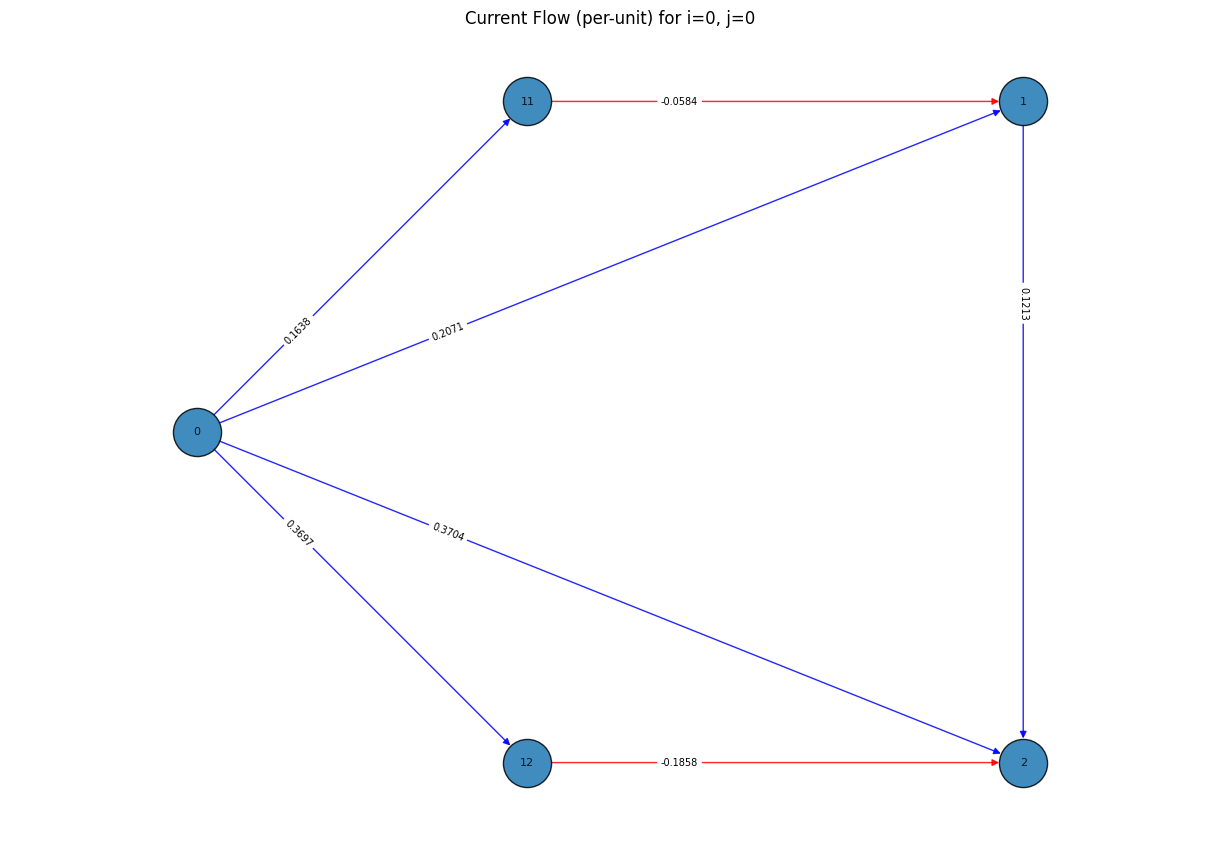

In [324]:
def plot_current_flow(m, i, j):
    pos = nx.get_node_attributes(G, 'pos')
    # Use node indices as labels
    labels = {n: n for n in G.nodes()}

    plt.figure(figsize=(12, 8))

    edge_colors = []
    edge_labels = {}

    for u, v in G.edges():
        try:
            # Get the current value from the model
            current_value = m.I[u, v, i, j].value
            if current_value is not None:
                edge_labels[(u, v)] = f"{round(current_value, 4)}"
                if current_value > 0:
                    edge_colors.append('blue')  # Positive current flow
                elif current_value < 0:
                    edge_colors.append('red')  # Negative current flow
                else:
                    edge_colors.append('gray') # No current flow
            else:
                edge_colors.append('gray') # No current value
        except:
            edge_colors.append('gray') # Handle cases where edge might not be in m.I

    nx.draw(
        G, pos,
        with_labels=True, labels=labels, # Set with_labels to True and pass node indices as labels
        node_size=1200,
        edge_color=edge_colors, # Use the calculated edge colors
        edgecolors="black", font_size=8,
        alpha=0.85
    )

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.3)

    plt.title(f"Current Flow (per-unit) for i={i}, j={j}")
    plt.axis("equal")
    plt.show()

# Example usage (assuming m, i=0, and j=0 are defined)
plot_current_flow(m, 0, 0)

In [415]:
B = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,2,2.05,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3]
#A = range(-3, 26)
alpha = 1.5
enveloppe_taille = []
curtail = []
close = []

for beta in B:
  print(alpha)
  def objective_rule(m):
    return  m.tot - alpha*m.O - beta * m.tot_bis
  m.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)
  params = {
    "WLSACCESSID": 'efa10779-150a-495c-ab62-6a20ff44c598',
    "WLSSECRET": 'fa980d94-a6fd-4d7b-aa68-b0e19ddd2e84',
    "LICENSEID": 2651433,
           }
  env = gp.Env(params=params)
  solver = pyo.SolverFactory('gurobi', env= env)
  results = solver.solve(m, tee=True)

  # Check the termination condition before accessing results
  if results.solver.termination_condition == pyo.TerminationCondition.optimal:
      curtail.append(m.O.value)
      enveloppe_taille.append(m.tot.value)
      close.append(m.tot_bis.value)

  else:
      # Append None for non-optimal results to maintain list length
      curtail.append(None)
      enveloppe_taille.append(None)
      close.append(None)

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpff9ohzb8.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xecc73478
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [5e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpebw24u4m.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xcecfdf3e
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [6e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpiouf3dbn.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x369aa5e9
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [7e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmprdcti04o.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x29d06e4b
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [8e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpj1fmx1mp.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xf12234bc
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [9e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpeaozujjw.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xf1159dee
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp28kfek69.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x6dfe4d24
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmph7ohk4o6.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xb6e7e7ca
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpvt6c13ta.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x973ee4d9
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpfsnppn3n.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xe3ff5c57
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp2fzts831.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x5ff1ed38
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00   3

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpldiyb306.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x706cb5e8
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00   3

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmphhwpwfoi.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x794882c7
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp9iduedq6.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xe86678f3
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpzbb1cz4f.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xc87780b4
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00   3

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpa6euqe34.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x8b9b3f03
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmptkujb_l8.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xb65964fa
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp59op_ebf.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x302528b5
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpjfqn84o6.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x47de1934
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp3momtp0p.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xf666440f
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp75_b3jh0.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0xd7ae1e57
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpir9j6i86.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x8e46cd59
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp4n8fheh7.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x1df94a44
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpe2jz8kvg.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x9eca06ca
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpa6w__b4j.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x6a221b99
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00   3

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().



Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpj2pplckl.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x77305d9e
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00   3

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


1.5
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp2m9tcfjf.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x18a5c859
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00 

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmpm3aw4mph.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x6aabc9ea
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00   3.

In [365]:
print(enveloppe_taille)
print(curtail)
print(close)

[5.108619633768047, 5.108619633768042, 5.108619633768042, 5.108619633768047, 5.108619633768047, 5.394662409934617, 6.332075999423944, 6.332075999423944, 6.332075999423944, 6.332075999423944, 6.332075999423944, 6.332075999423944, 6.304925290006747, 6.304925290006747, 6.304925290006747, 6.304925290006747, 6.304925290006747, 6.304925290006747, 6.304925290006747, 6.304925290006747, 6.304925290006747, 6.304925290006747, 6.304925290006747, 6.304925290006747, 6.304925290006747, 6.304925290006747, 6.304925290006747, 6.304925290006747]
[1.5849266707208456, 1.5849266707208456, 1.5849266707208456, 1.5849266707208456, 1.5849266707208456, 1.8709694468874245, 2.80838303637675, 2.80838303637675, 2.80838303637675, 2.80838303637675, 2.80838303637675, 2.80838303637675, 2.845662645003374, 2.845662645003374, 2.845662645003374, 2.845662645003374, 2.845662645003374, 2.845662645003374, 2.845662645003374, 2.845662645003374, 2.845662645003374, 2.845662645003374, 2.845662645003374, 2.845662645003374, 2.84566264

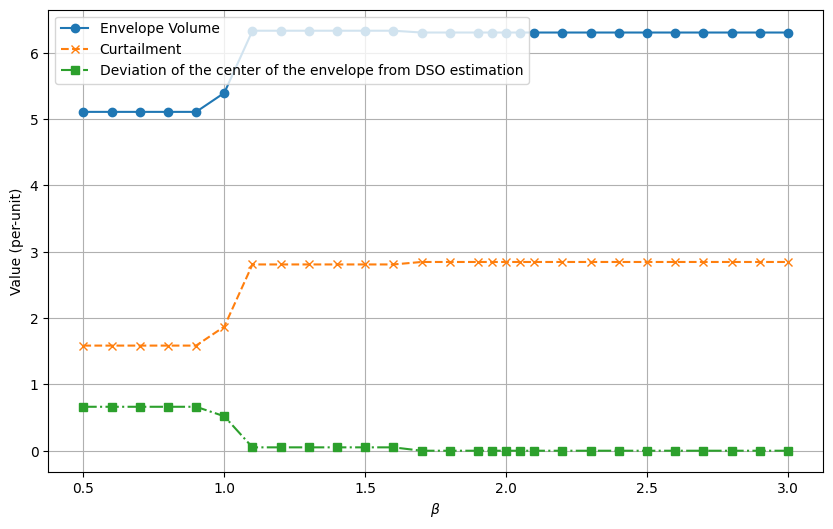

In [366]:
# Convert A to a numpy array for easier plotting
alpha_values = np.array(B)

# Convert lists to numpy arrays, replacing None with NaN for plotting
enveloppe_taille_np = np.array(enveloppe_taille, dtype=float)
curtail_np = np.array(curtail, dtype=float)
close_np = np.array(close, dtype=float)


plt.figure(figsize=(10, 6))

# Plot enveloppe_taille vs alpha
plt.plot(alpha_values, enveloppe_taille_np, marker='o', linestyle='-', label='Envelope Volume')

# Plot curtail vs alpha
plt.plot(alpha_values, curtail_np, marker='x', linestyle='--', label='Curtailment')

# Plot close vs alpha
plt.plot(alpha_values, close_np, marker='s', linestyle='-.', label='Deviation of the center of the envelope from DSO estimation')


# Set x-axis to a logarithmic scale
#plt.xscale('log')

# Save the plot as a PDF file


plt.xlabel('$\\beta$')
plt.ylabel('Value (per-unit)')
#plt.title(f'Evolution of the volume of the envelope, curtailment and closeness to estimation as a function of parameter $\\beta$ ($\\alpha$ = 2)')
plt.legend()
plt.grid(True)
plt.savefig('DOE_alloc_beta.pdf')

plt.show()

In [427]:
beta = 100
alpha = 2
enveloppe_taille = []
curtail = []
close = []


print(alpha)
def objective_rule(m):
  return  m.tot - alpha*m.O - beta * m.tot_bis
m.objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)
params = {
    "WLSACCESSID": 'efa10779-150a-495c-ab62-6a20ff44c598',
    "WLSSECRET": 'fa980d94-a6fd-4d7b-aa68-b0e19ddd2e84',
    "LICENSEID": 2651433,
           }
env = gp.Env(params=params)
solver = pyo.SolverFactory('gurobi', env= env)
results = solver.solve(m, tee=True)

  # Check the termination condition before accessing results
if results.solver.termination_condition == pyo.TerminationCondition.optimal:
  curtail.append(m.O.value)
  enveloppe_taille.append(m.tot.value)
  close.append(m.tot_bis.value)

else:

      # Append None for non-optimal results to maintain list length
  curtail.append(None)
  enveloppe_taille.append(None)
  close.append(None)

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


2
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2651433
Academic license 2651433 - for non-commercial use only - registered to an___@student.uliege.be
Read LP format model from file /tmp/tmp0gp1z4k5.pyomo.lp
Reading time = 0.00 seconds
x1: 438 rows, 179 columns, 808 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 438 rows, 179 columns and 808 nonzeros
Model fingerprint: 0x208a1061
Coefficient statistics:
  Matrix range     [5e-01, 2e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+01]
Presolve removed 377 rows and 117 columns
Presolve time: 0.00s
Presolved: 61 rows, 62 columns, 228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7473859e+00   

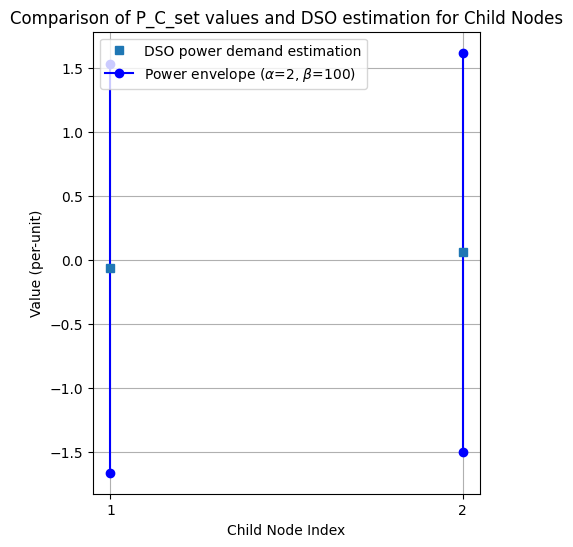

In [428]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
children_nodes = list(m.children)
p_c_set_0_values = [m.P_C_set[n, 0].value for n in m.children]
p_c_set_1_values = [m.P_C_set[n, 1].value for n in m.children]
info_dso_values = [m.info_DSO_param[n] for n in m.children]

# Create the plot
plt.figure(figsize=(5, 6))

# Adjust x_pos to control spacing (e.g., reduce the multiplier)
x_pos = np.arange(len(children_nodes)) * 0.0005 # Reduced spacing by multiplying by 0.0005

# Plot lines between P_C_set[n][0] and P_C_set[n][1] for each child node
for i in range(len(children_nodes)):
    plt.plot([x_pos[i], x_pos[i]], [p_c_set_1_values[i], p_c_set_0_values[i]], marker='o', linestyle='-', color='blue')

# Plot only dots for info_DSO_param
plt.plot(x_pos, info_dso_values, marker='s', linestyle='', label=f'DSO power demand estimation')

# Create legend handles for the P_C_set endpoints
# We plot invisible points with the desired labels to create legend entries
plt.plot([], [], marker='o', linestyle='-', color='blue', label=f'Power envelope ($\\alpha$={alpha}, $\\beta$={beta})')


plt.xticks(x_pos, children_nodes)
plt.xlabel('Child Node Index')
plt.ylabel('Value (per-unit)')
plt.title('Comparison of P_C_set values and DSO estimation for Child Nodes')
plt.legend(loc='upper left') # Move the legend to the upper left
plt.grid(True)

# Draw labels to the left of the points
# for i, n in enumerate(children_nodes):
#     # Label for the upper bound of the envelope
#     plt.text(x_pos[i], p_c_set_0_values[i], f"{round(p_c_set_0_values[i], 4)}", fontsize=8, ha='center', va='bottom', color='red')
#     # Label for the lower bound of the envelope
#     plt.text(x_pos[i], p_c_set_1_values[i], f"{round(p_c_set_1_values[i], 4)}", fontsize=8, ha='center', va='top', color='red')
#     # Label for the DSO estimation
#     plt.text(x_pos[i], info_dso_values[i], f"{round(info_dso_values[i], 4)}", fontsize=8, ha='center', va='center', color='green')


# Save the plot as a PDF file
plt.savefig('child_nodes_envelopes.pdf')

plt.show()